**Netflix**, a video streaming and internet company, has provided a dataset of customers with various account details and whether they churned or not. In this project, we will explore patterns in customer churn and build models to predict churn risk and give data-driven solutions of intervention at the end. Understanding churn drivers can help Netflix retain valuable customers.

In [1]:
!pip install shap -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
pd.options.display.max_columns = None
pd.options.display.max_rows = 10
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Data_Science_Product_Manager/telecom_customer_churn.csv")

df

viewer_id  gender  age married  number_of_family_dependents city  \
0     0002-ORFBO  Female   37     Yes                            0   SD   
1     0003-MKNFE    Male   46      No                            0   SD   
2     0004-TLHLJ    Male   50      No                            0   SD   
3     0011-IGKFF    Male   78     Yes                            0   SD   
4     0013-EXCHZ  Female   75     Yes                            0   SD   
...          ...     ...  ...     ...                          ...  ...   
6583  9986-BONCE  Female   36      No                            0   SJ   
6584  9987-LUTYD  Female   20      No                            0   SJ   
6585  9992-RRAMN    Male   40     Yes                            0   SJ   
6586  9993-LHIEB    Male   21     Yes                            0   SJ   
6587  9995-HOTOH    Male   36     Yes                            0   SJ   

      zip_code   latitude   longitude  number_of_referrals  tenure_in_months  \
0        93225  34.827662 -118.999073                    2                 9   
1        91206  34.162515 -118.203869                    0                 9   
2        92627  33.645672 -117.922613                    0                 4   
3        94553  38.014457 -122.115432                    1                13   
4        93010  34.227846 -119.079903                    3                 3   
...        ...        ...         ...                  ...               ...   
6583     92028  33.362575 -117.299644                    0                 4   
6584     91941  32.759327 -116.997260                    0                13   
6585     95367  37.734971 -120.954271                    1                22   
6586     92075  33.001813 -117.263628                    5                67   
6587     96125  39.600599 -120.636358                    1                63   

        offer internet_service internet_type  avg_monthly_gb_download  \
0        None              Yes         Cable                     16.0   
1        None              Yes         Cable                     10.0   
2     Offer E              Yes   Fiber Optic                     30.0   
3     Offer D              Yes   Fiber Optic                      4.0   
4        None              Yes   Fiber Optic                     11.0   
...       ...              ...           ...                      ...   
6583     None               No           NaN                      NaN   
6584  Offer D              Yes           DSL                     59.0   
6585  Offer D              Yes   Fiber Optic                     17.0   
6586  Offer A              Yes         Cable                     58.0   
6587     None              Yes         Cable                      5.0   

     online_security online_backup device_protection_plan  \
0                 No           Yes                     No   
1                 No            No                     No   
2                 No            No                    Yes   
3                 No           Yes                    Yes   
4                 No            No                     No   
...              ...           ...                    ...   
6583             NaN           NaN                    NaN   
6584             Yes            No                     No   
6585              No            No                     No   
6586             Yes            No                    Yes   
6587             Yes           Yes                    Yes   

     premium_tech_support streaming_tv streaming_movies streaming_music  \
0                     Yes          Yes               No              No   
1                      No           No              Yes             Yes   
2                      No           No               No              No   
3                      No          Yes              Yes              No   
4                     Yes          Yes               No              No   
...                   ...          ...              ...             ...   
6583      

# **Data Cleaning**

In [4]:
df.isnull().sum(), df.isnull().sum().max()

(viewer_id                      0
 gender                         0
 age                            0
 married                        0
 number_of_family_dependents    0
                               ..
 total_refunds                  0
 total_extra_data_charges       0
 total_long_distance_charges    0
 total_revenue                  0
 viewer_status                  0
 Length: 33, dtype: int64,
 1344)

In [5]:
with pd.option_context('display.max_rows', None):
    display(df.isnull().sum())

viewer_id                         0
gender                            0
age                               0
married                           0
number_of_family_dependents       0
city                              0
zip_code                          0
latitude                          0
longitude                         0
number_of_referrals               0
tenure_in_months                  0
offer                             0
internet_service                  0
internet_type                  1344
avg_monthly_gb_download        1344
online_security                1344
online_backup                  1344
device_protection_plan         1344
premium_tech_support           1344
streaming_tv                   1344
streaming_movies               1344
streaming_music                1344
unlimited_hi-res_streaming     1344
subscription_type                 0
paperless_billing                 0
payment_method                    0
monthly_charge                    0
total_charges               

**fillna with meaningful values**

In [6]:
df['internet_type'] = df['internet_type'].fillna('None')
df['avg_monthly_gb_download'] = df['avg_monthly_gb_download'].fillna(0.0)
df = df.fillna('No')
df = df.drop(columns=['viewer_id'])
df.isnull().sum().max()

0

In [7]:
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = df.select_dtypes(include=['number']).columns.tolist()
cat_features, num_features

(['gender',
  'married',
  'city',
  'offer',
  'internet_service',
  'internet_type',
  'online_security',
  'online_backup',
  'device_protection_plan',
  'premium_tech_support',
  'streaming_tv',
  'streaming_movies',
  'streaming_music',
  'unlimited_hi-res_streaming',
  'subscription_type',
  'paperless_billing',
  'payment_method',
  'viewer_status'],
 ['age',
  'number_of_family_dependents',
  'zip_code',
  'latitude',
  'longitude',
  'number_of_referrals',
  'tenure_in_months',
  'avg_monthly_gb_download',
  'monthly_charge',
  'total_charges',
  'total_refunds',
  'total_extra_data_charges',
  'total_long_distance_charges',
  'total_revenue'])

# **Exploratory Data Analysis**

## **Numerical Features:**

### **Univariate Analysis**

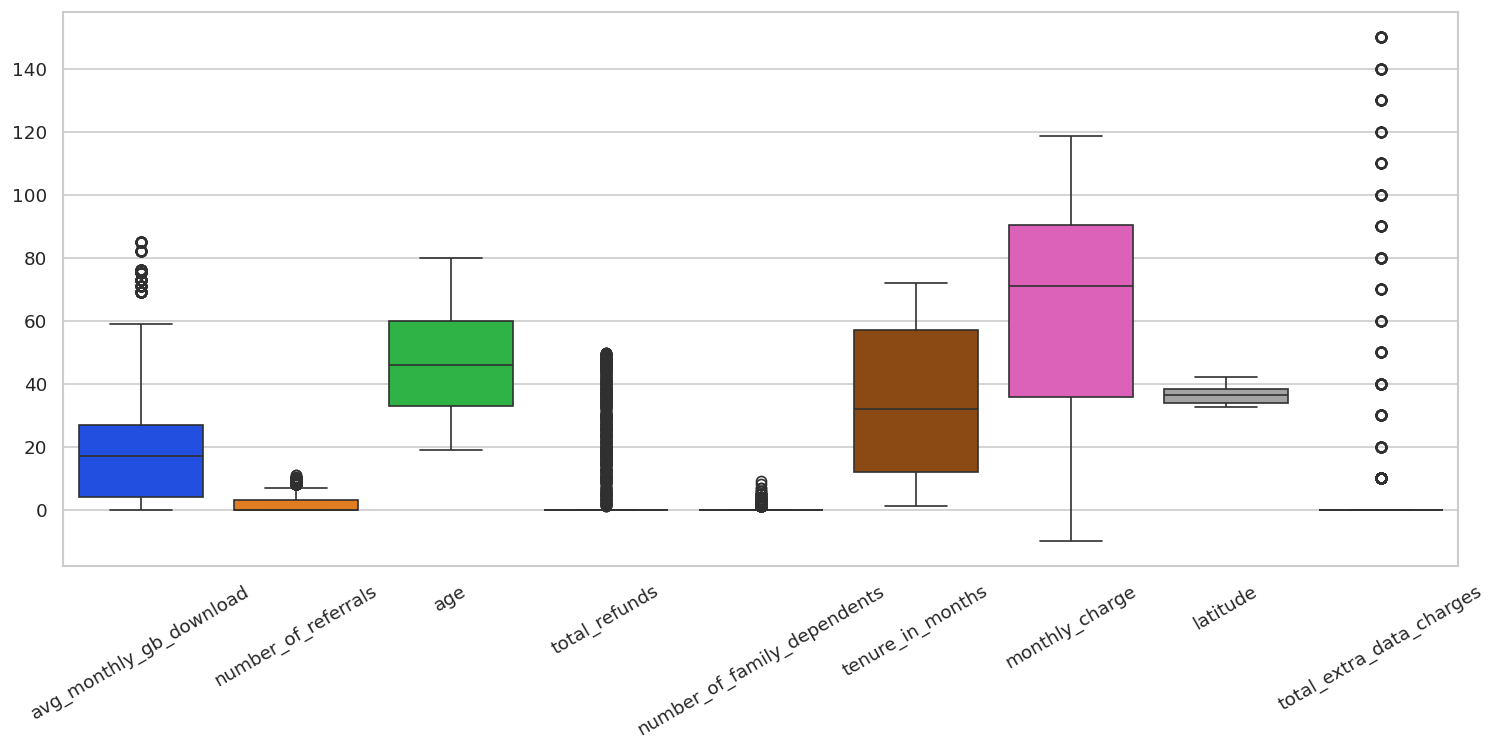

In [9]:
sns.set(style='whitegrid', palette='bright')
plt.figure(figsize=(15,6), dpi=120)
sns.boxplot(df[set(num_features)-set(['zip_code','total_long_distance_charges', 'total_revenue', 'total_charges', 'lagitude', 'longitude'])])
plt.xticks(rotation=30)
plt.show()


First of all, before transpassing all the analysis, we will need to know the distribution of each variables in the data set
the box plot could show the distribution and the existance of the outliers.\
from the chart below, we can find that the monthly charge for the customer is fall in the range from ~ 35 to 90
dominant composition of our customers are aged from 35 yrs old to 60 yrs old, which expressed the certain purchase power of the customers.\
the distribution of total refunds represented that major group of customers are not likely to drop off form the subscription (high customer stickiness) \
the avg_monthly_gb_download -> the app's online feature (e.g. UI/UX design, system processing time, content matching score, etc.) will tend to have larger impact if change\
Major customers will likely to keep the subscription for  ~ 58 months in max (10 months to 58 months will be good to post retentional promotion)

<Axes: xlabel='number_of_family_dependents', ylabel='Density'>

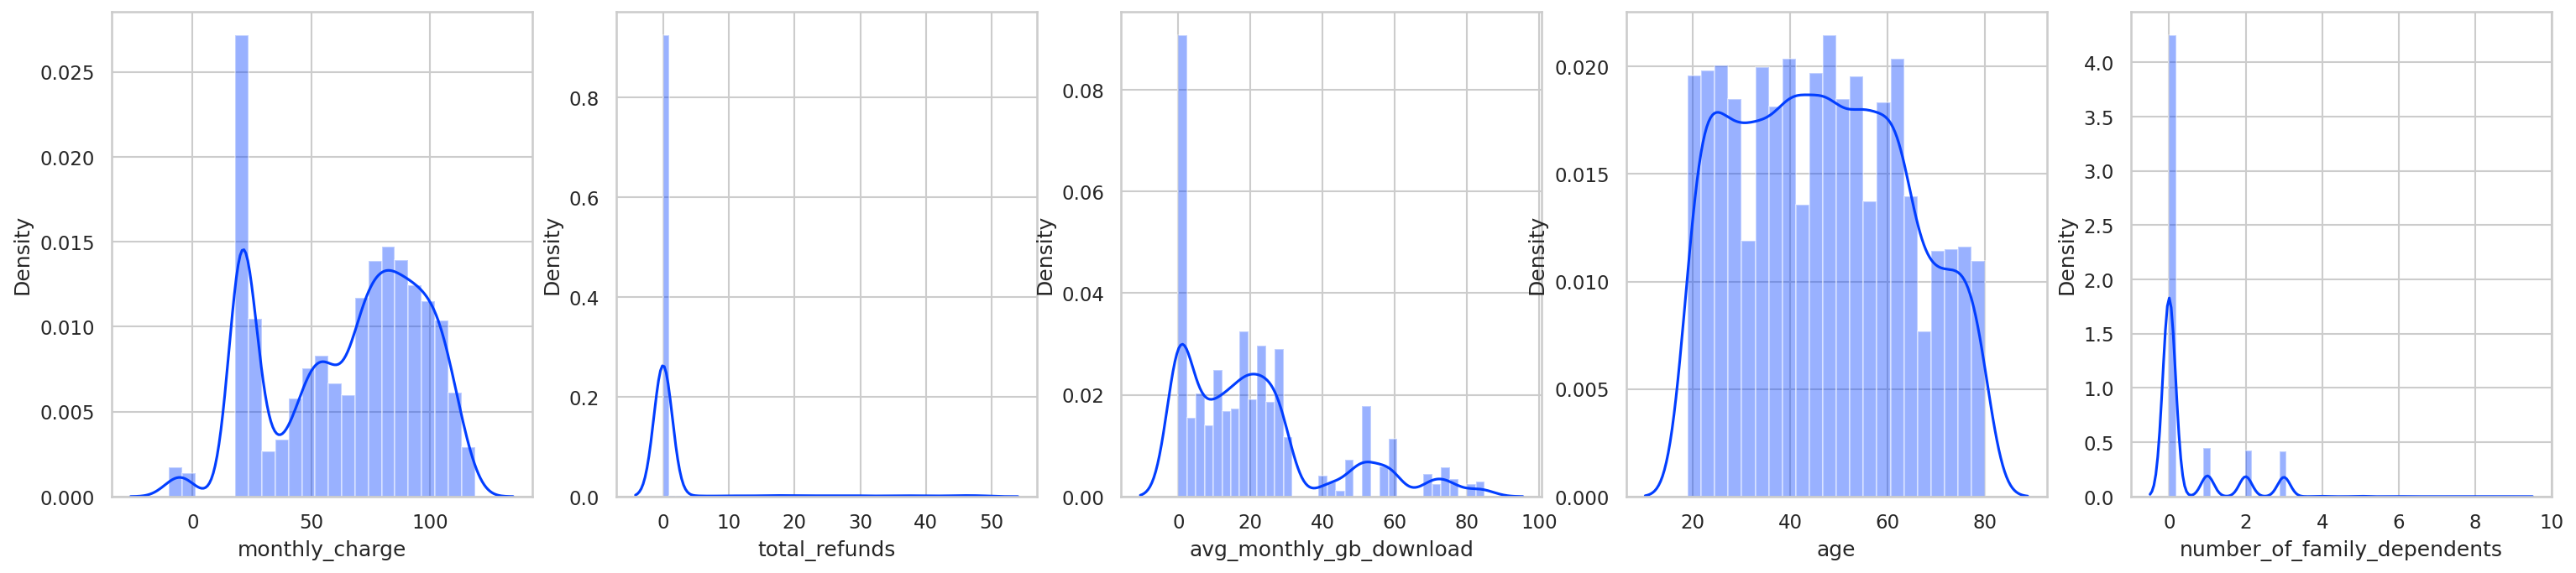

In [10]:
fig, (ax1,ax2,ax3,ax4, ax5) = plt.subplots(1,5, figsize=(25,5), dpi=150)

sns.distplot(df['monthly_charge'], ax = ax1)
sns.distplot(df['total_refunds'], ax = ax2)
sns.distplot(df['avg_monthly_gb_download'], ax = ax3)
sns.distplot(df['age'], ax = ax4)
sns.distplot(df['number_of_family_dependents'], ax = ax5)


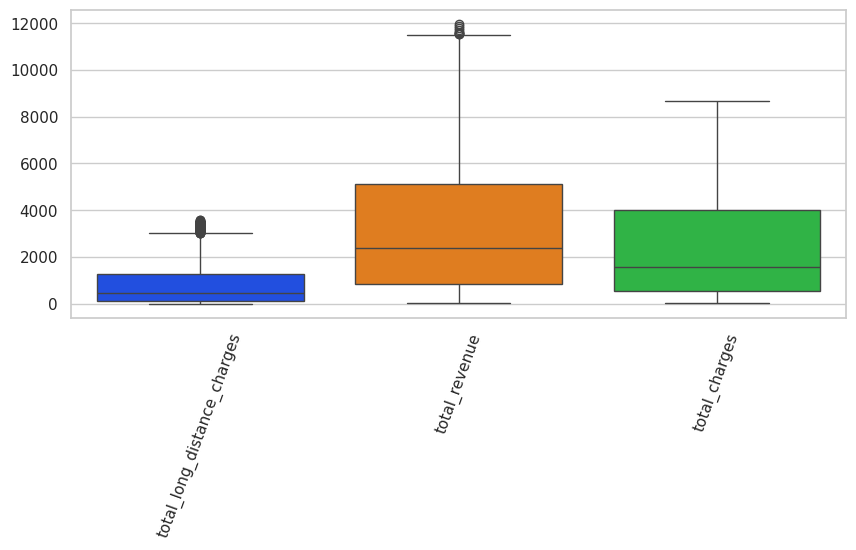

In [11]:
sns.set(style='whitegrid', palette='bright')
plt.figure(figsize=(10,4), dpi=100)
sns.boxplot(df[['total_long_distance_charges', 'total_revenue', 'total_charges']])
plt.xticks(rotation=70)
plt.show()

<Axes: xlabel='viewer_status', ylabel='Count'>

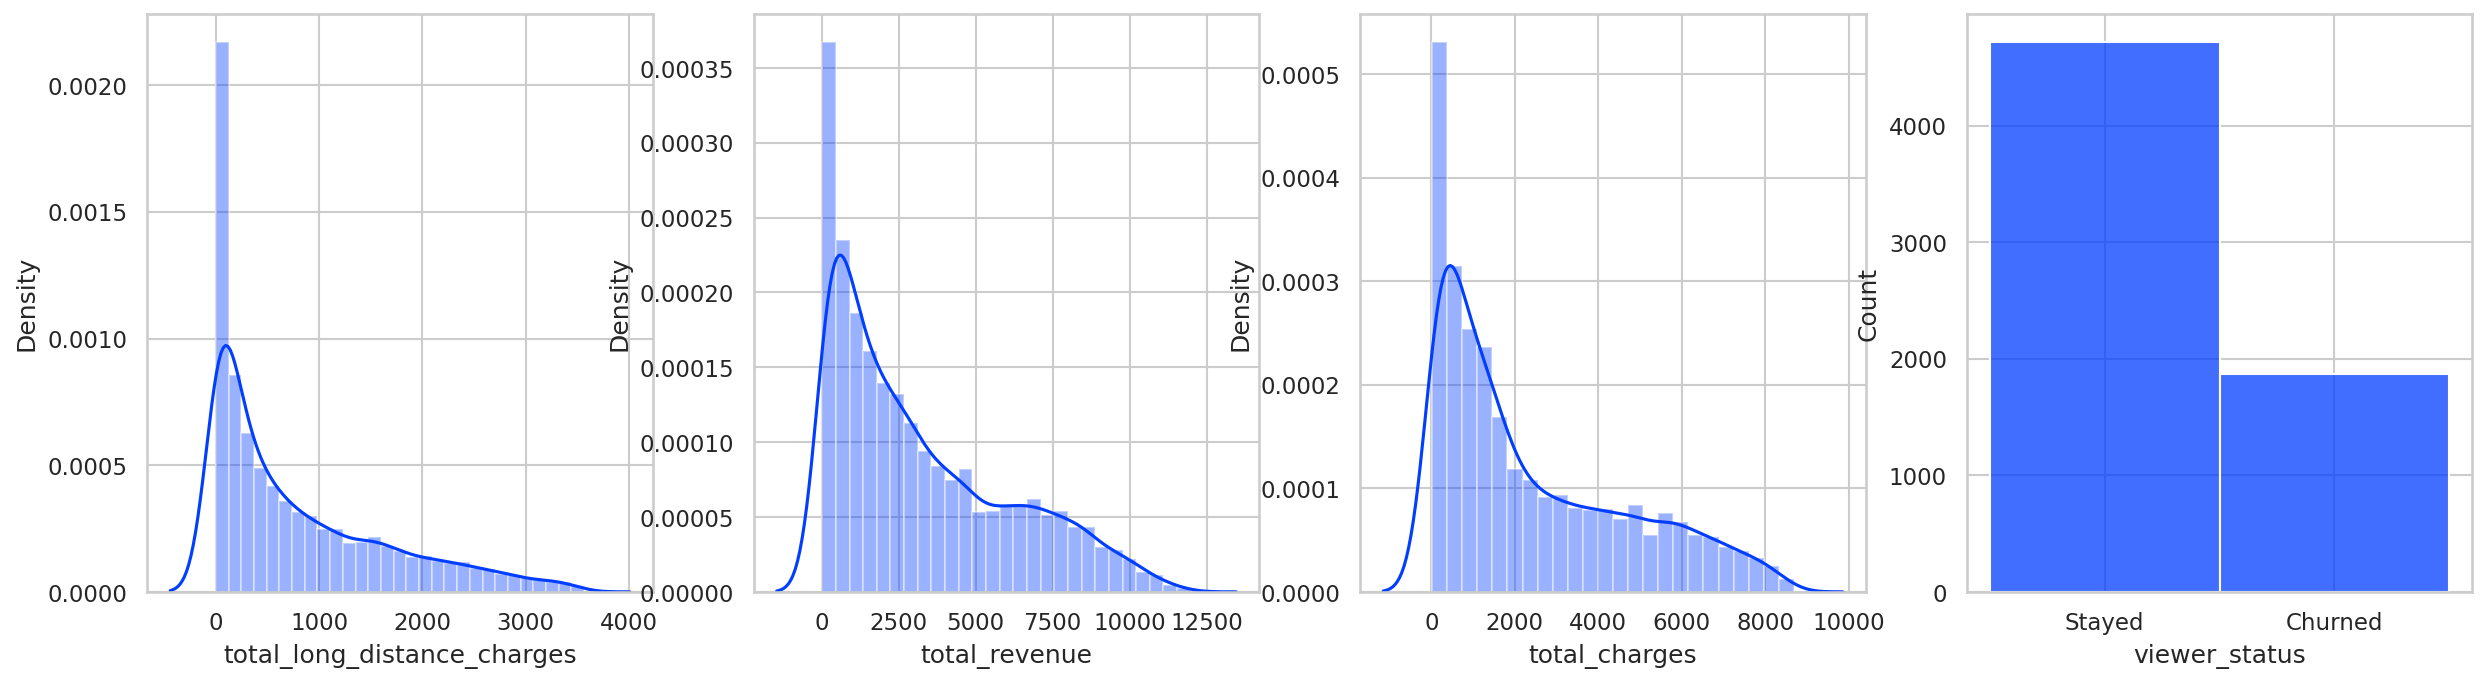

In [12]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,5), dpi=150)

sns.distplot(df['total_long_distance_charges'], ax = ax1)
sns.distplot(df['total_revenue'], ax = ax2)
sns.distplot(df['total_charges'], ax = ax3)
sns.histplot(df['viewer_status'], ax = ax4)

<Axes: >

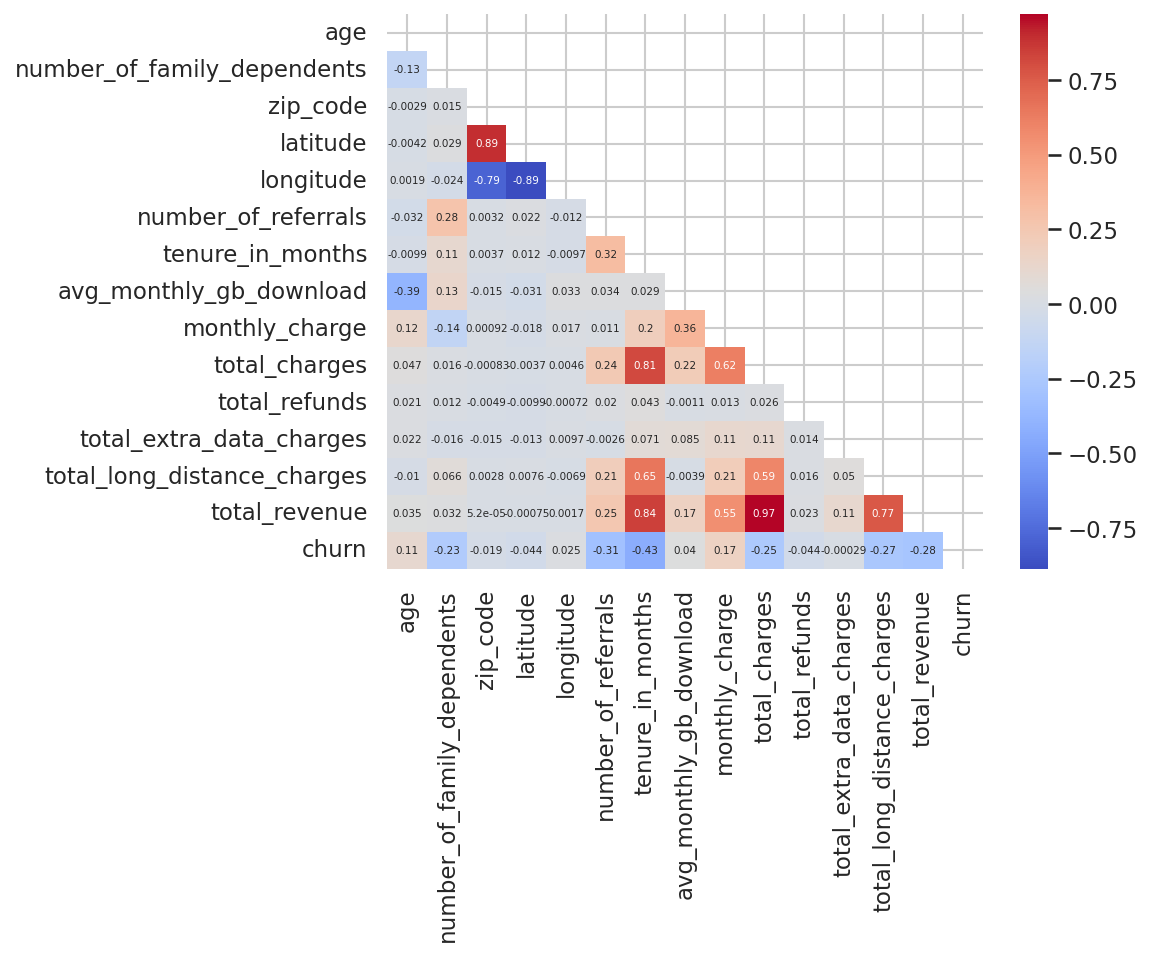

In [13]:
plt.figure(dpi=150)
df_temp = df.copy()
df_temp['churn'] = df['viewer_status'].apply(lambda x:1.0 if x=='Churned' else 0.0)
df_temp = df_temp[num_features+['churn']]
cor = df_temp.corr()
sns.heatmap(cor, annot=True, annot_kws={'size':5}, cmap='coolwarm', mask = np.triu(cor))



As we can find in the heat map:\
Churn is positively correlated to age, and monthly charge.\
Churn is negatively correlated to number of family dependents, number of referrals, tenure in months, total revenue, total charges.\
But correlation only gives a rough idea of the variables, does not imply causality.

### **Bivariate Analysis**

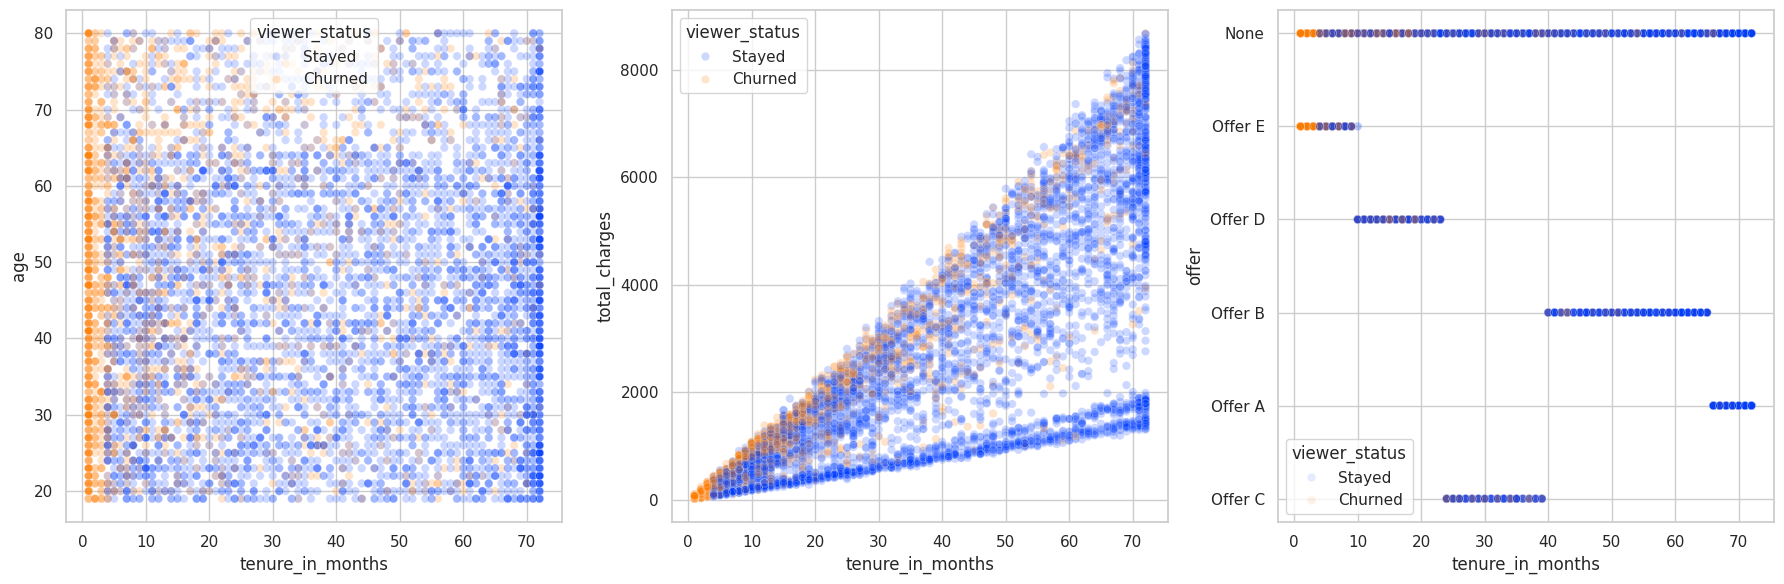

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.scatterplot(data=df, x='tenure_in_months', y='age', hue='viewer_status', ax=axs[0], alpha=0.2)

sns.scatterplot(data=df, x='tenure_in_months', y='total_charges', hue='viewer_status', ax=axs[1], alpha=0.2)

sns.scatterplot(data=df, x='tenure_in_months', y='offer', hue='viewer_status', ax=axs[2], alpha=0.1)

plt.tight_layout()
plt.show()

It is interesting to see a huge amount of <font color='red'>churn happens in 1-2 months after enroll<font color='black'>, maybe just after the free trail, and they finished steaming what they wanted to see at the first place and churn.\
Don't waste the golden period of retention, we can give them best price offer! Get them in in a very low price, and let people <font color='red'>grow their streaming habits with netflix<font color='black'> is essential! \
The churned people mostly have a high price subscription from the slope of total charged by time curve, why they choose that 17.99 subscriptions instead of the 9.99 dollar subscription is a question... Let them know about the 9.99 plan, and make it easy to switch instead of forever churn please.

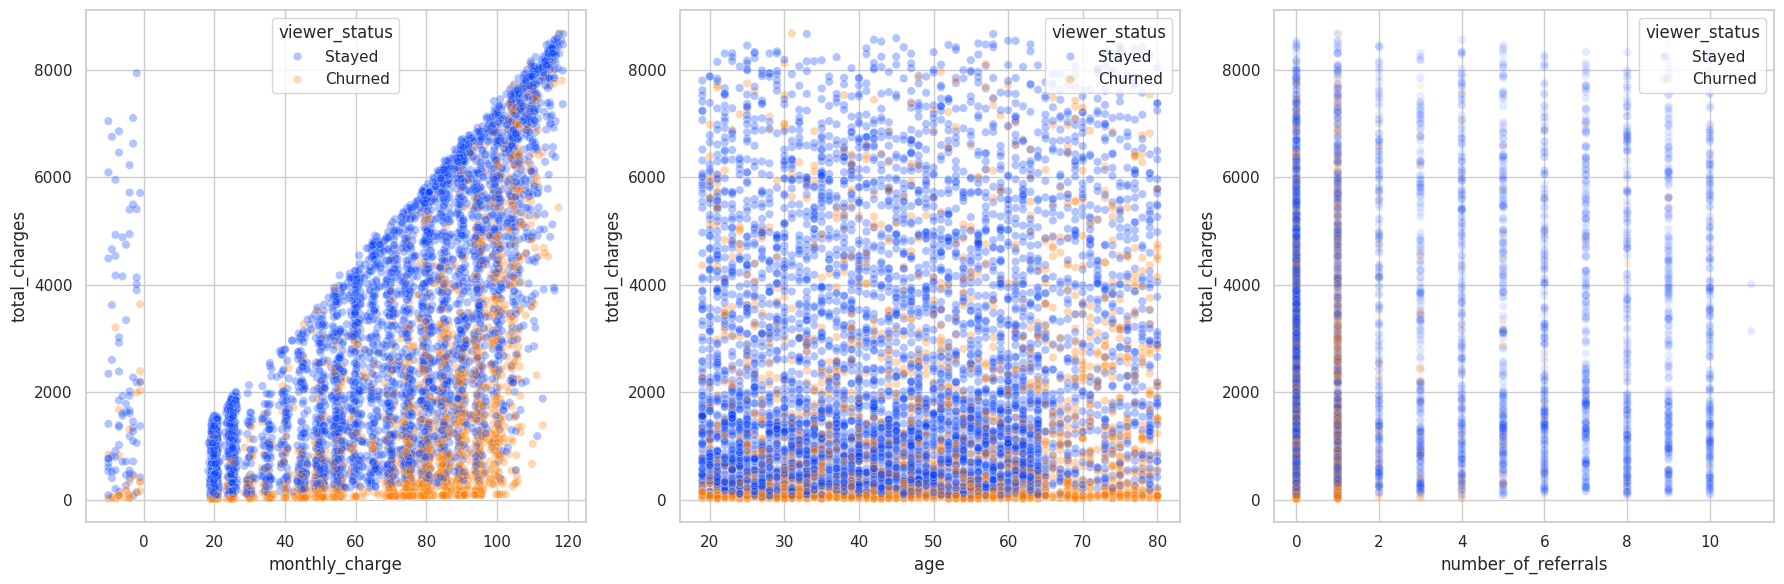

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.scatterplot(data=df, x='monthly_charge', y='total_charges', hue='viewer_status', ax=axs[0], alpha=0.3)

sns.scatterplot(data=df, x='age', y='total_charges', hue='viewer_status', ax=axs[1], alpha=0.3)

sns.scatterplot(data=df, x='number_of_referrals', y='total_charges', hue='viewer_status', ax=axs[2], alpha=0.1)

plt.tight_layout()
plt.show()


It is very interesting to see that many churned people have high monthly charge, and low total charges. Probably because they are for some reasons enrolled in a very <font color='red'>high cost plan <font color='black'>that they feel not deserve or not feed their needs so they don't want it anymore. In this case, they churn. <font color='red'>Recommendations of low cost plans that better feed their needs and show them what other similar users subscribe ina lower price would be helpful!

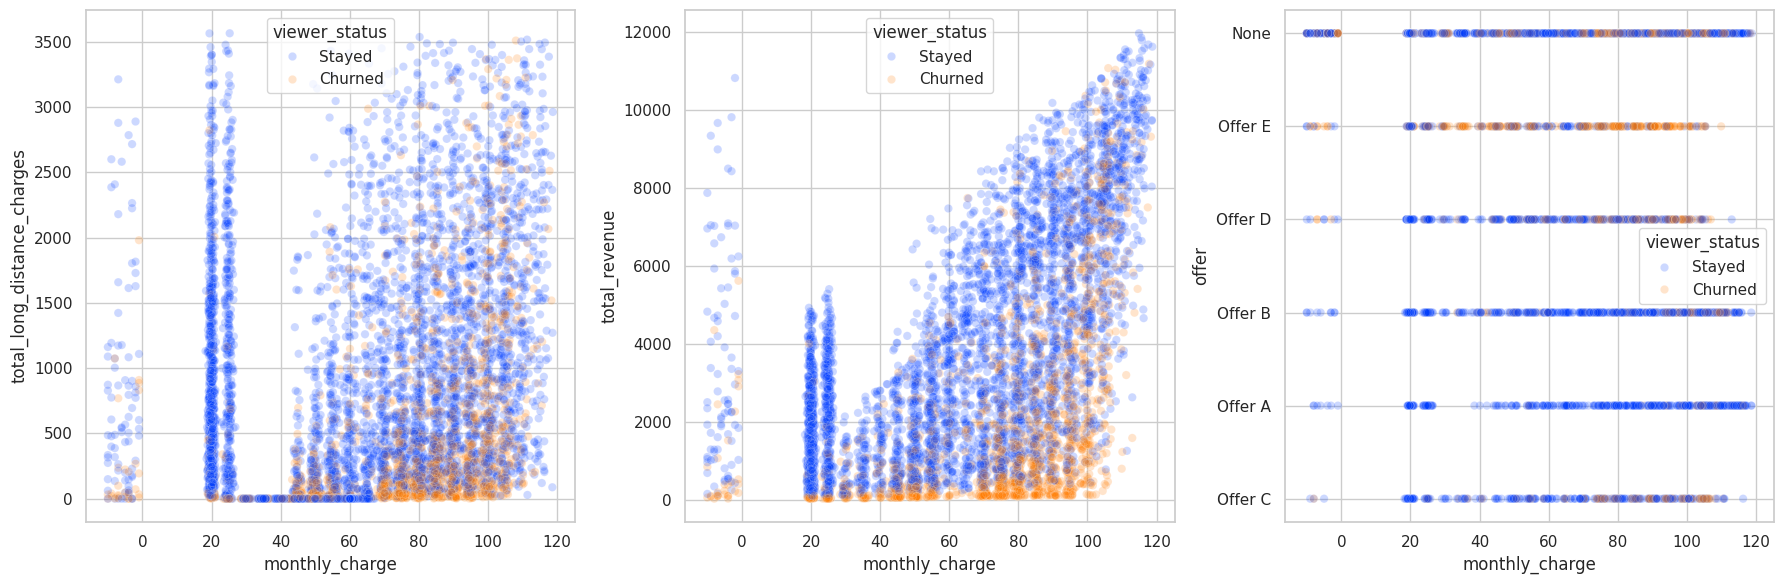

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.scatterplot(data=df, x='monthly_charge', y='total_long_distance_charges', hue='viewer_status', ax=axs[0], alpha=0.2)

sns.scatterplot(data=df, x='monthly_charge', y='total_revenue', hue='viewer_status', ax=axs[1], alpha=0.2)

sns.scatterplot(data=df, x='monthly_charge', y='offer', hue='viewer_status', ax=axs[2], alpha=0.2)

plt.tight_layout()
plt.show()

The people of 20 monthly charge plan is very very stable, most of them do not churn. 70-100 subscription is very likely to churn.\
People with no offer and <font color='red'>offer E is very likely to churn<font color='black'>. What kind of offer is that?? Some bundle with higher prices?? Or is it because we know they are very likely to churn, so we give them offer E, and they churn anyways?

## **Categorical Featrues**

### **Univariate Analysis**

In [17]:
cat_features

['gender',
 'married',
 'city',
 'offer',
 'internet_service',
 'internet_type',
 'online_security',
 'online_backup',
 'device_protection_plan',
 'premium_tech_support',
 'streaming_tv',
 'streaming_movies',
 'streaming_music',
 'unlimited_hi-res_streaming',
 'subscription_type',
 'paperless_billing',
 'payment_method',
 'viewer_status']

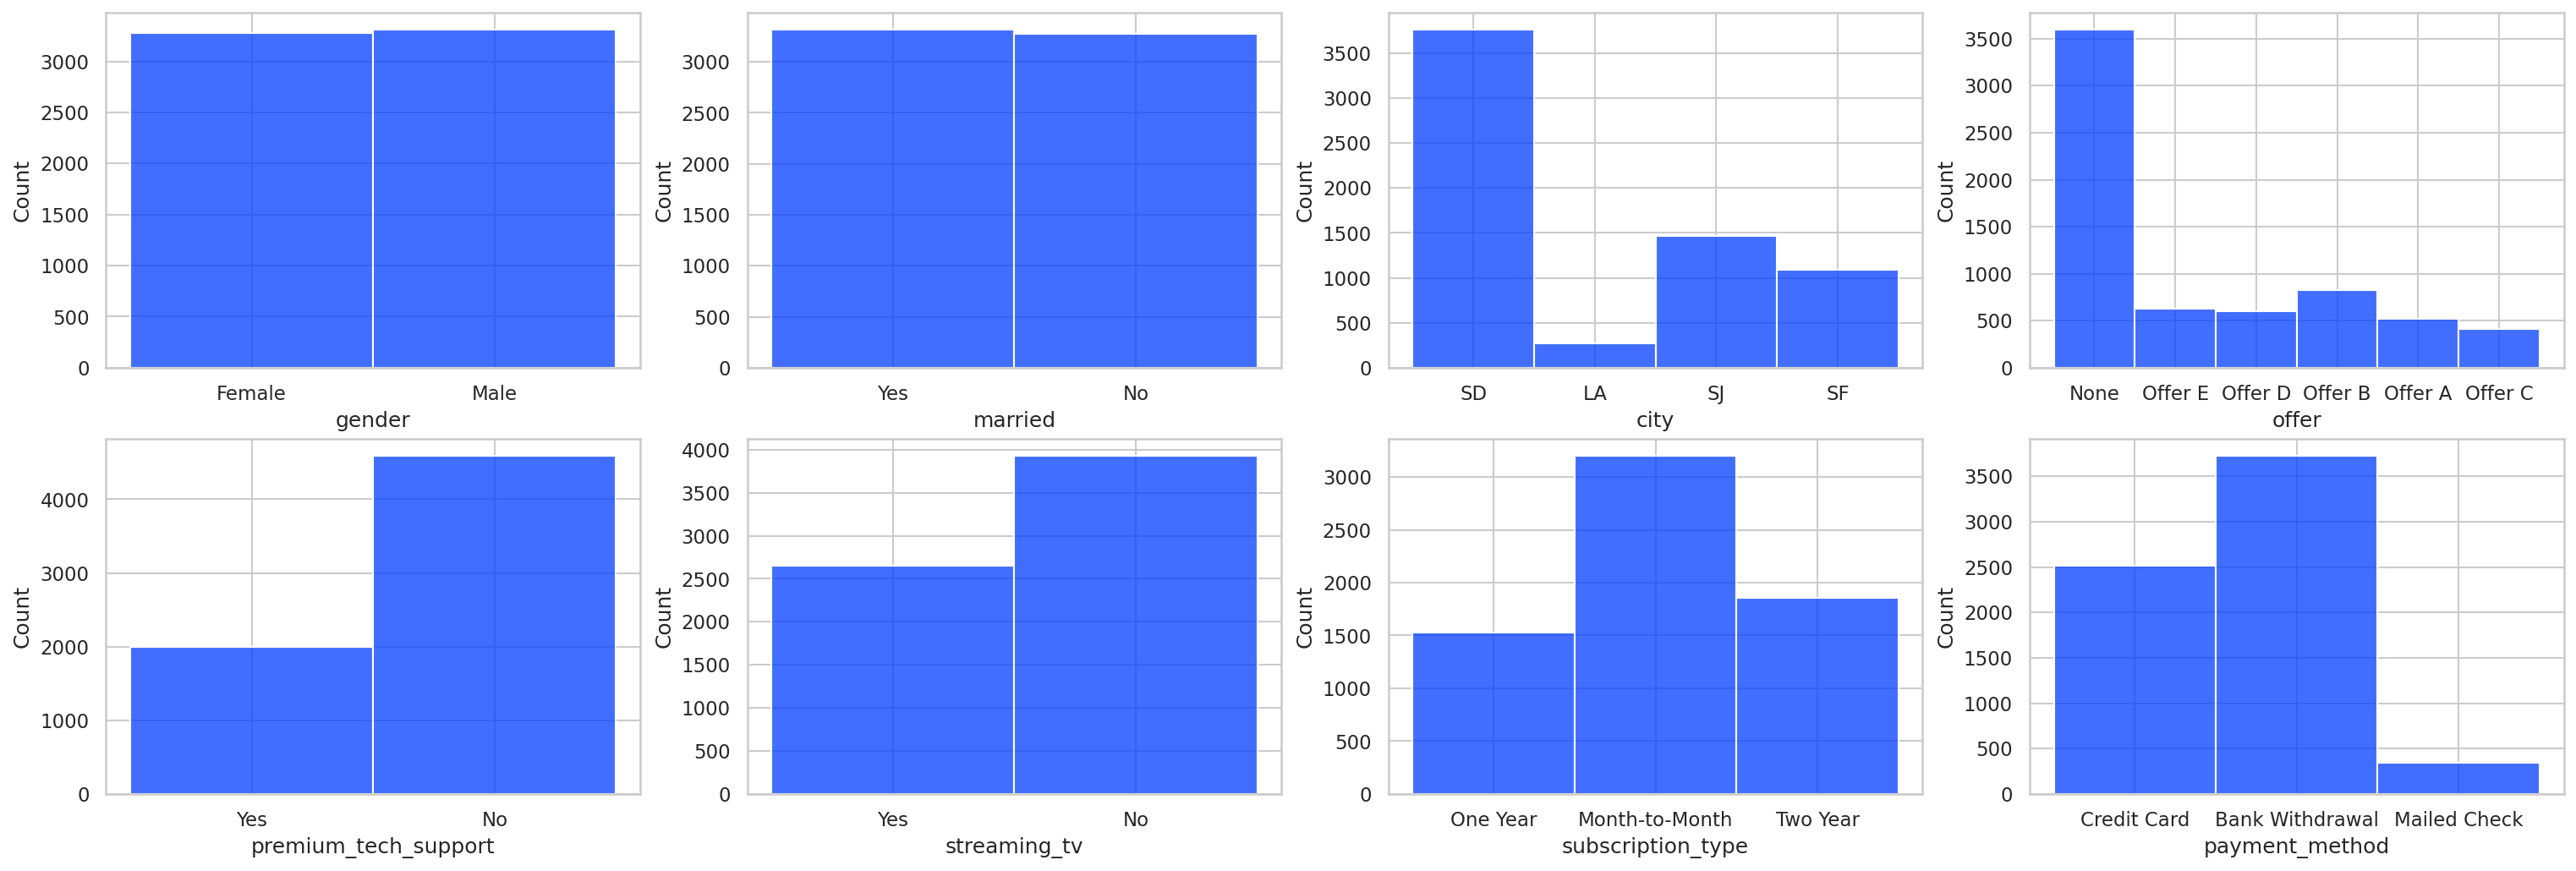

In [18]:
fig, ax = plt.subplots(2,4,figsize=(25,8), dpi=150)
ax = ax.ravel()
interests = ['gender', 'married', 'city', 'offer', 'premium_tech_support', 'streaming_tv', 'subscription_type', 'payment_method']
for i, cat in enumerate(interests):
  sns.histplot(df[cat], ax=ax[i])


Gender, Marriage Status pretty balanced. Most data in San Diego, then San Jose, San Francisco, the LA. Most people don't have offer? I am suprised! 3/10 people have premium tech support. 4/10 people stream TV. Most people subscribe Month to Month, there are decent amount of people subscribe one year, two years.

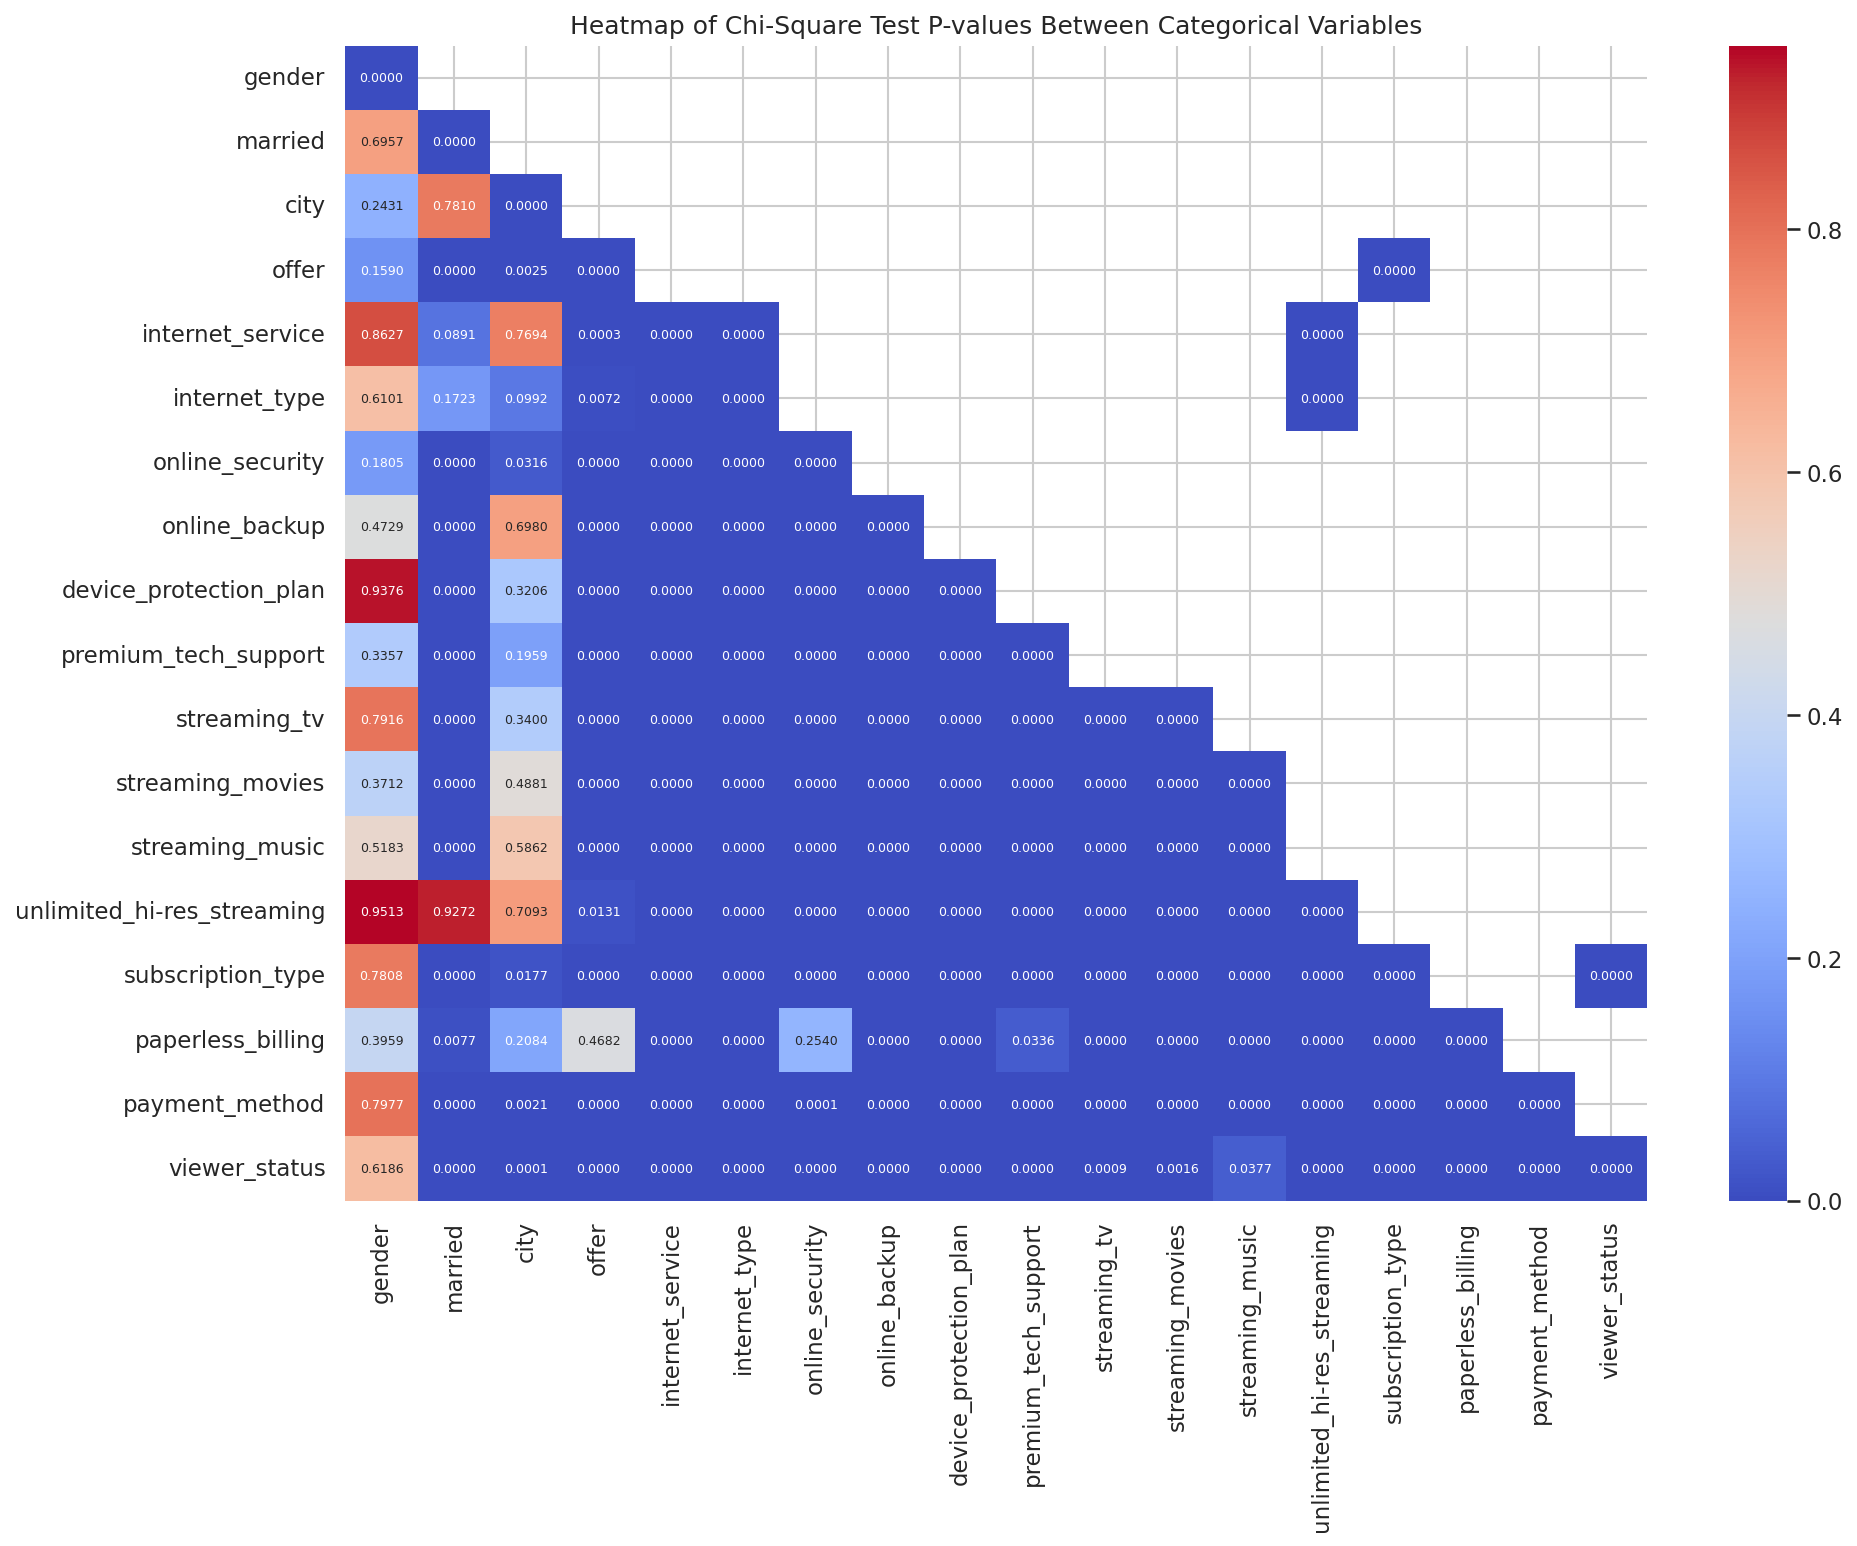

In [19]:
from scipy.stats import chi2_contingency

# Identify categorical variables and the target variable 'viewer_status'
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col not in ['viewer_id']]

chi2_results = np.zeros((len(categorical_columns), len(categorical_columns)))
# Perform chi-square tests
for i, col1 in enumerate(categorical_columns):
    for j, col2 in enumerate(categorical_columns):
        if i == j:  # Skip the diagonal (comparison with itself)
            chi2_results[i, j] = 0
        else:
          contingency_table = pd.crosstab(df[col1], df[col2])
          chi2, p, dof, expected = chi2_contingency(contingency_table)
          chi2_results[i, j] = p  # Store the p-value

# Create a DataFrame from the chi2_results for easier plotting
chi2_results_df = pd.DataFrame(chi2_results, index=categorical_columns, columns=categorical_columns)

# Plot a heatmap of the p-values
plt.figure(figsize=(14, 10),dpi=150)
sns.heatmap(chi2_results_df, annot=True, cmap='coolwarm', fmt=".4f", mask=np.triu(chi2_results_df), annot_kws={'size':6})
plt.title('Heatmap of Chi-Square Test P-values Between Categorical Variables')
plt.show()


From Chi-squared test for categorical variable, the heatmap shows p values, smaller p value shows more significant correlation. Churn are <font color='red'>correlated with all but gender.

### **Bivariate Analysis**

In [20]:
viewer_counts = df.groupby(['gender', 'viewer_status']).size().reset_index(name='counts')

gender_totals = viewer_counts.groupby('gender')['counts'].sum().reset_index(name='total_counts')

viewer_counts = viewer_counts.merge(gender_totals, on='gender')

viewer_counts['proportion'] = viewer_counts['counts'] / viewer_counts['total_counts']
viewer_counts['labels'] = viewer_counts['viewer_status'] + ' (' + (viewer_counts['proportion'] * 100).round(1).astype(str) + '%)'
viewer_counts

gender viewer_status  counts  total_counts  proportion           labels
0  Female       Churned     939          3276    0.286630  Churned (28.7%)
1  Female        Stayed    2337          3276    0.713370   Stayed (71.3%)
2    Male       Churned     930          3312    0.280797  Churned (28.1%)
3    Male        Stayed    2382          3312    0.719203   Stayed (71.9%)

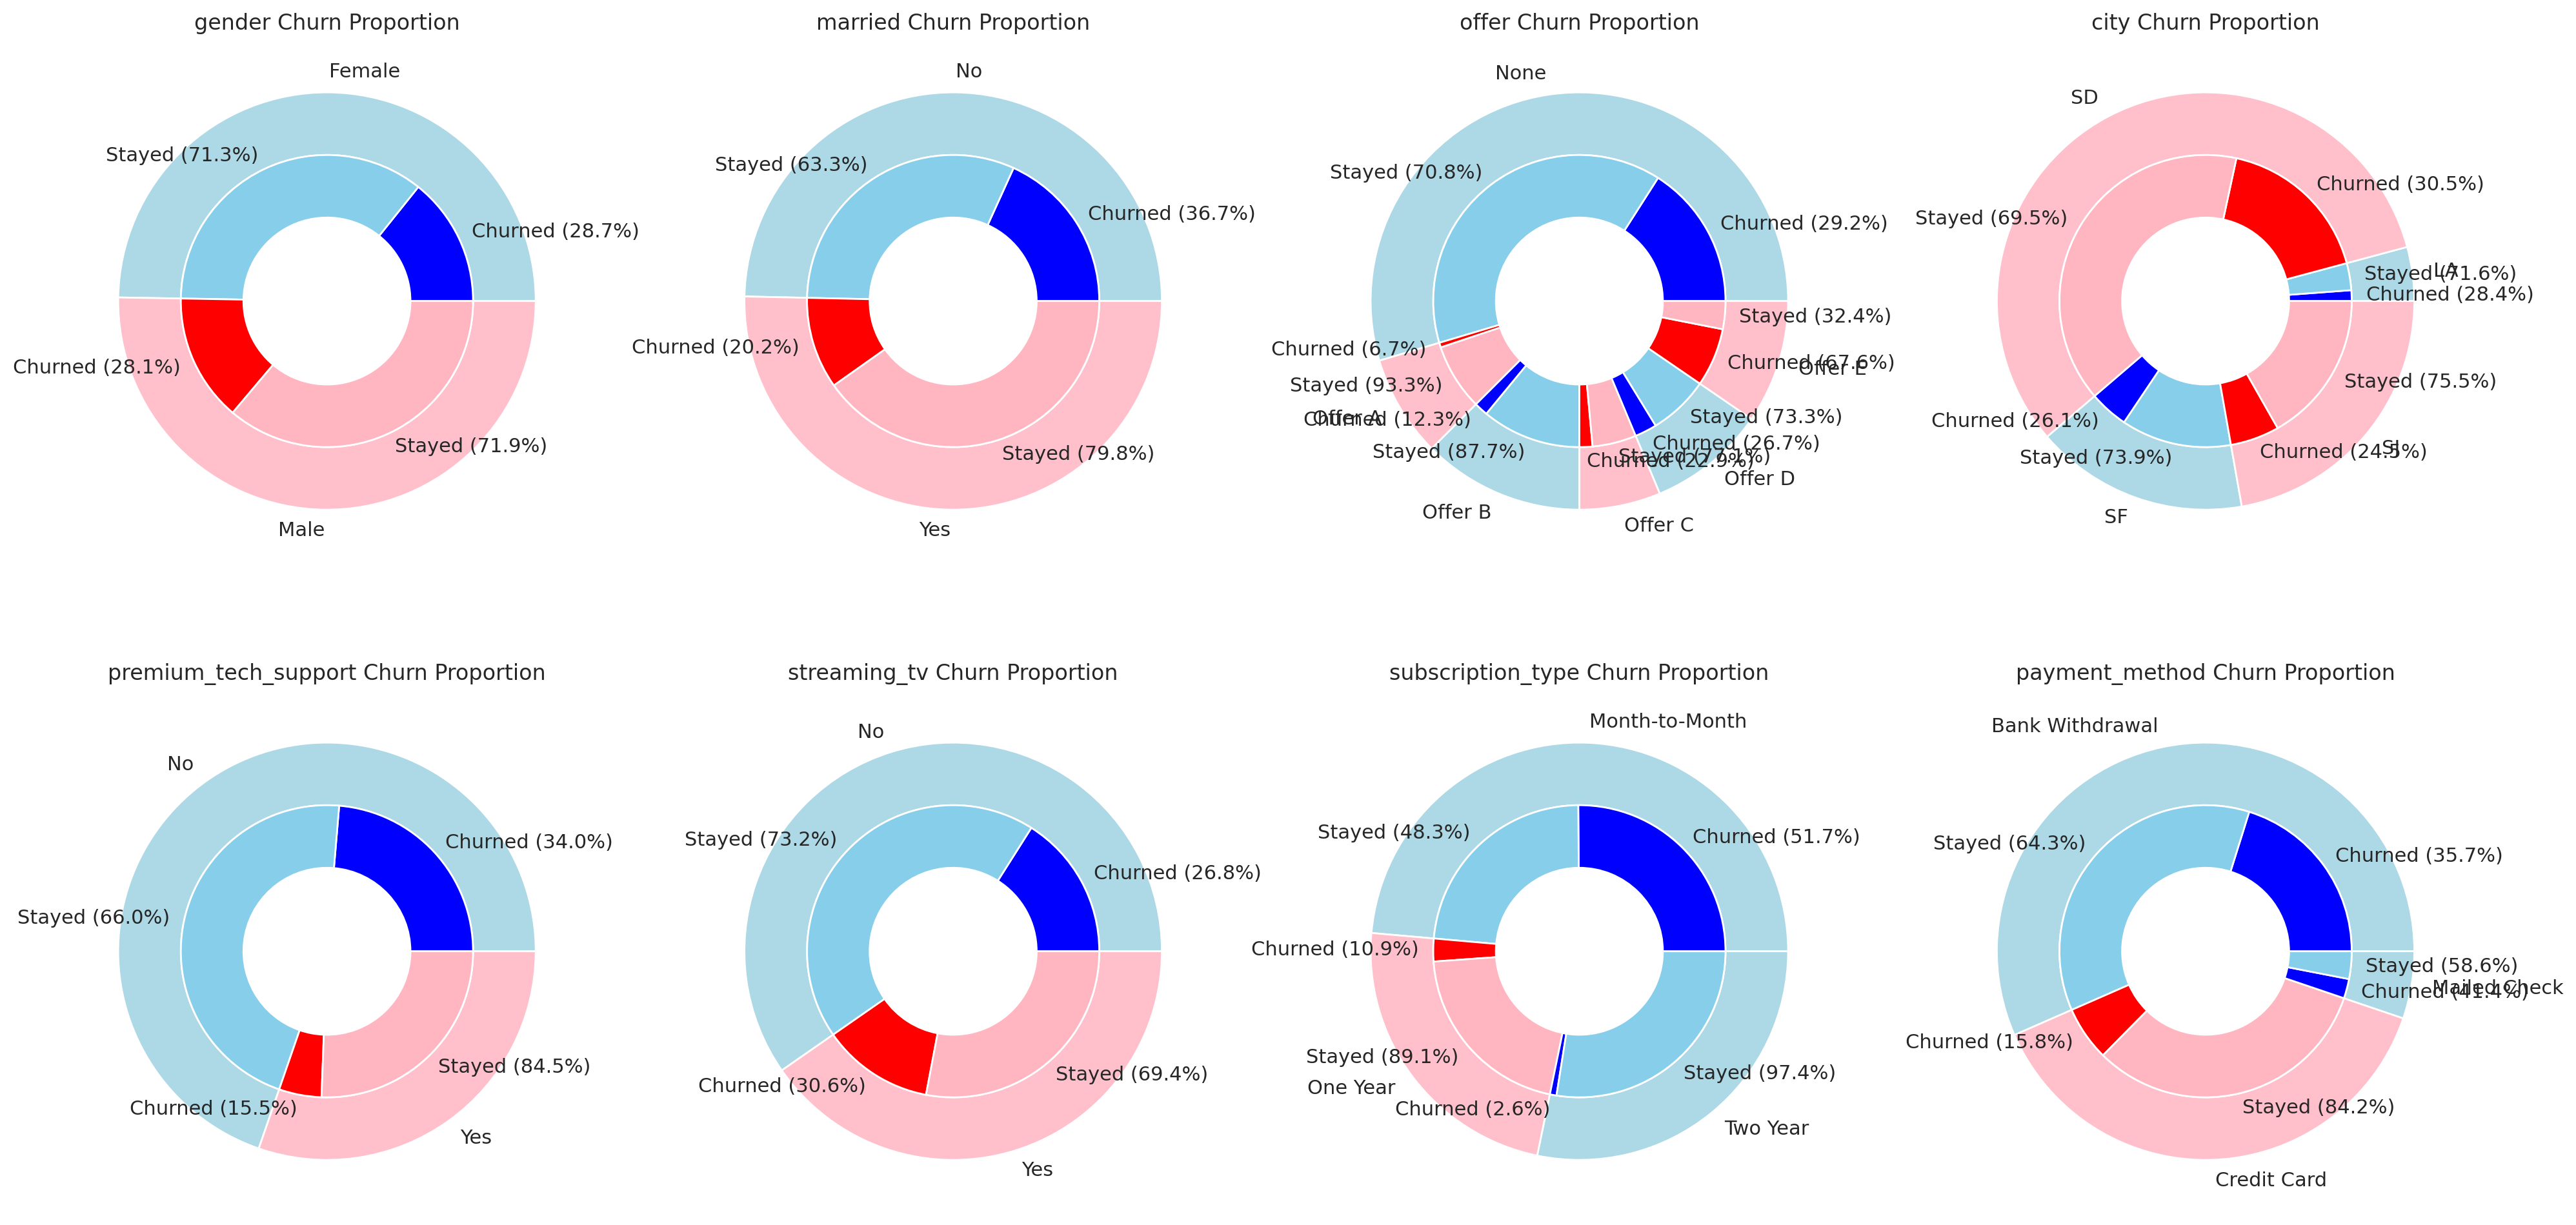

In [21]:
fig, ax = plt.subplots(2,4, figsize=(24,12), dpi=200)
ax = ax.ravel()
interests = ['gender', 'married', 'offer', 'city', 'premium_tech_support', 'streaming_tv', 'subscription_type', 'payment_method']
colors_outer = ['lightblue', 'pink']
colors_inner = ['blue', 'skyblue', 'red' , 'lightpink']

for i, cat in enumerate(interests):
  viewer_counts = df.groupby([cat, 'viewer_status']).size().reset_index(name='counts')

  gender_totals = viewer_counts.groupby(cat)['counts'].sum().reset_index(name='total_counts')

  viewer_counts = viewer_counts.merge(gender_totals, on=cat)

  viewer_counts['proportion'] = viewer_counts['counts'] / viewer_counts['total_counts']
  viewer_counts['labels'] = viewer_counts['viewer_status'] + ' (' + (viewer_counts['proportion'] * 100).round(1).astype(str) + '%)'

  ax[i].pie(viewer_counts.groupby(cat)['counts'].sum(), labels=viewer_counts[cat].unique(),
        radius=1, colors=colors_outer, wedgeprops=dict(width=0.3, edgecolor='w'))

  ax[i].pie(viewer_counts['counts'], labels=viewer_counts['labels'], radius=0.7,
        colors=colors_inner, wedgeprops=dict(width=0.3, edgecolor='w'))

  ax[i].set_title(cat+" Churn Proportion")
plt.show()

Nice donut charts!\
Again gender is very balanced in terms of churn rate.\
<font color='red'>Non-married people<font color='black'> have a higher proportion to churn than married. Reversed as seens later in modeling after controling confounders\
<font color='red'>Offer E<font color='black'> has a higher churn rate.\
<font color='red'>San Diego<font color='black'> people have a higher churn rate than SJ, SF, LA, why??\
People with premium tech support has a lower churn rate.\
Month-to-Month subscription has a <font color='red'>51.7% churn rate<font color='black'>...Two year subsciption only 2.6%, yea they paid the money for two years...\
People who pay with bank withdrawal have a 35.7% churn rate much higher than credit card 15.8% Wow, probably we want to <font color='red'>promote paying with credit card!


Text(0.5, 1.0, 'offer Churn Proportion')

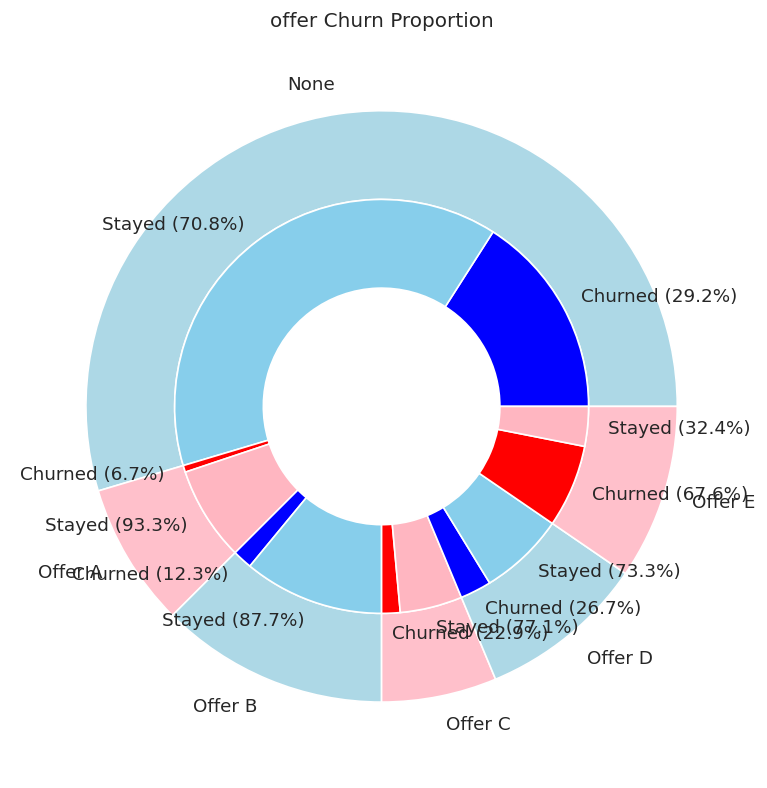

In [22]:
plt.figure(figsize=(8,8), dpi=120)
cat = 'offer'
viewer_counts = df.groupby([cat, 'viewer_status']).size().reset_index(name='counts')

gender_totals = viewer_counts.groupby(cat)['counts'].sum().reset_index(name='total_counts')

viewer_counts = viewer_counts.merge(gender_totals, on=cat)

viewer_counts['proportion'] = viewer_counts['counts'] / viewer_counts['total_counts']
viewer_counts['labels'] = viewer_counts['viewer_status'] + ' (' + (viewer_counts['proportion'] * 100).round(1).astype(str) + '%)'

plt.pie(viewer_counts.groupby(cat)['counts'].sum(), labels=viewer_counts[cat].unique(),
      radius=1, colors=colors_outer, wedgeprops=dict(width=0.3, edgecolor='w'))

plt.pie(viewer_counts['counts'], labels=viewer_counts['labels'], radius=0.7,
      colors=colors_inner, wedgeprops=dict(width=0.3, edgecolor='w'))
plt.title(cat+" Churn Proportion")

In [23]:
pd.crosstab(df['gender'], df['viewer_status'], normalize='index')

viewer_status   Churned    Stayed
gender                           
Female         0.286630  0.713370
Male           0.280797  0.719203

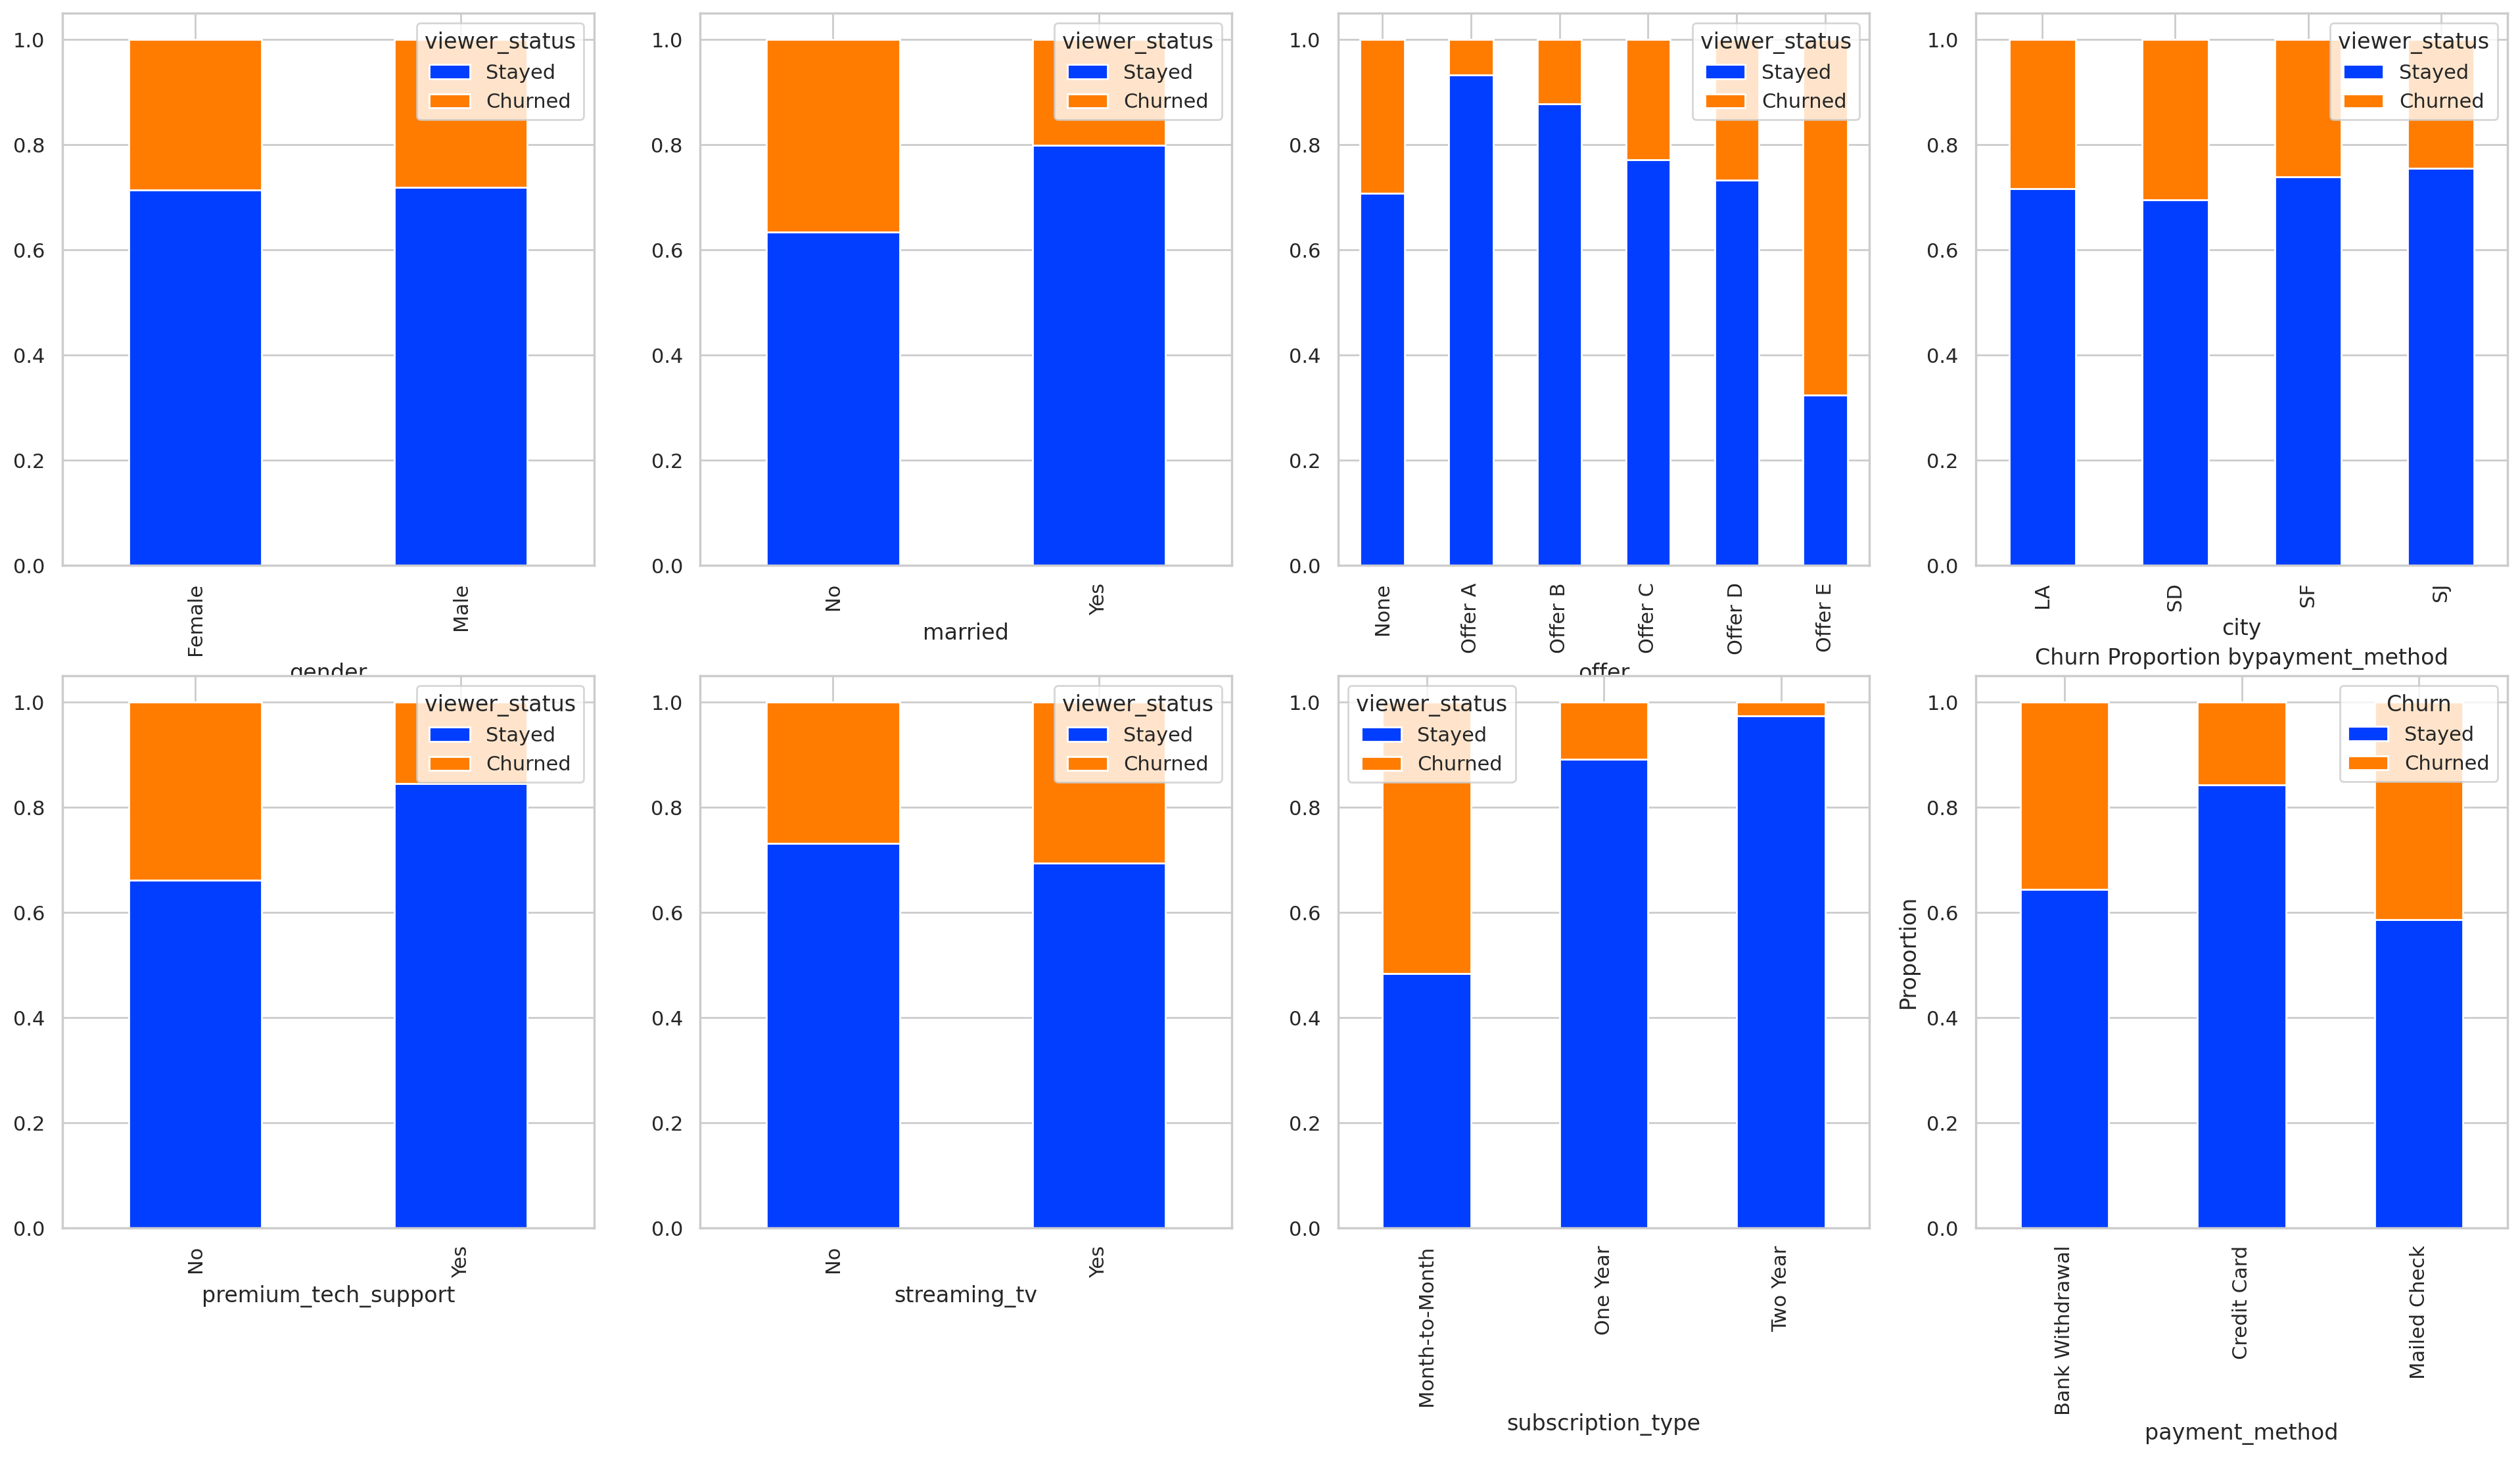

In [24]:
fig, ax = plt.subplots(2,4, figsize=(24,12), dpi=200)
ax = ax.ravel()
for i, cat in enumerate(interests):
  cross_tab = pd.crosstab(df[cat], df['viewer_status'], normalize='index')[['Stayed', 'Churned']]

  cross_tab.plot(kind='bar', stacked=True, ax=ax[i])
  plt.title('Churn Proportion by'+ cat)
  plt.xlabel(cat)
  plt.ylabel('Proportion')
plt.legend(title='Churn', loc='upper right')
plt.show()

# **Customer Segmentation Analysis**

## **Kmeans ++**

kmeans...:   0%|          | 0/28 [00:00<?, ?it/s]

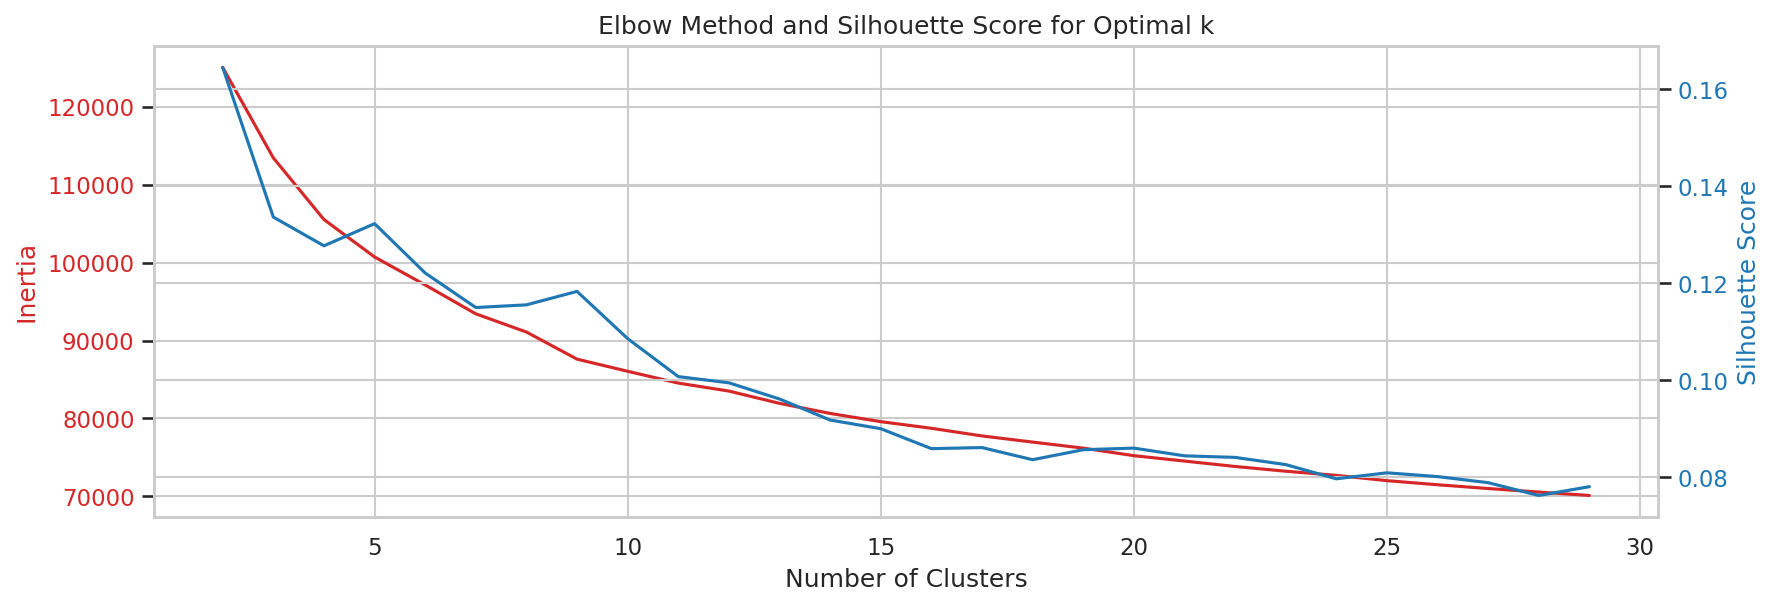

In [25]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

X = df.drop(['viewer_status'], axis=1)
y = df['viewer_status']

# Create the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), list(set(cat_features)-set(['viewer_status'])))
    ])

# Fit the preprocessing pipeline on the data
X_preprocessed = preprocessor.fit_transform(X)

# Use the elbow method to determine the optimal number of clusters
inertia = []
silhouette_scores = []
range_values = range(2, 30)

for i in tqdm(range_values, "kmeans..."):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42).fit(X_preprocessed)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_preprocessed, kmeans.labels_))

# Plotting the Elbow Method graph
fig, ax1 = plt.subplots(figsize=(12,4),dpi=150)

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(range_values, inertia, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range_values, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Elbow Method and Silhouette Score for Optimal k')
plt.show()


Tradding off Silhouette(isolation) score with Inertia(compactness), and we pick <font color='red'>number of clusters=5 <font color='black'>for better visulizations.

In [26]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(X_preprocessed)
df_cluster = df.copy()
df_cluster['cluster'] = np.array(kmeans.labels_)

viewer_status    Stayed   Churned
cluster                          
0              0.130844  0.104888
1              0.187158  0.017304
2              0.221463  0.030965
3              0.138130  0.117486
4              0.038707  0.013054

<Figure size 960x720 with 0 Axes>

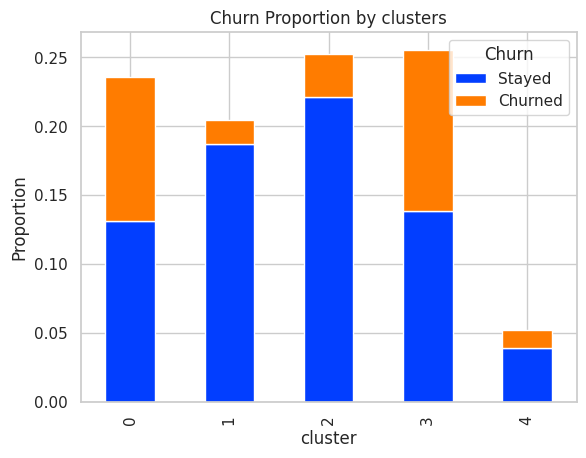

In [27]:
crosstab = pd.crosstab(df_cluster['cluster'], df_cluster['viewer_status'], normalize=True)[['Stayed', 'Churned']]
display(crosstab)
plt.figure(dpi=150)
crosstab.plot(kind='bar', stacked=True)
plt.title('Churn Proportion by clusters')
plt.ylabel('Proportion')
plt.legend(title='Churn', loc='upper right')
plt.show()

People in <font color='red'>cluters 0 and 3<font color='black'> have very high Churn Rate, let's see what variables seperate them from other people?\
**Pay attention to <font color='fuchsia'> cluster 0 <font color='black'> and <font color='orange'> cluster 3 <font color='black'>in the graph.**

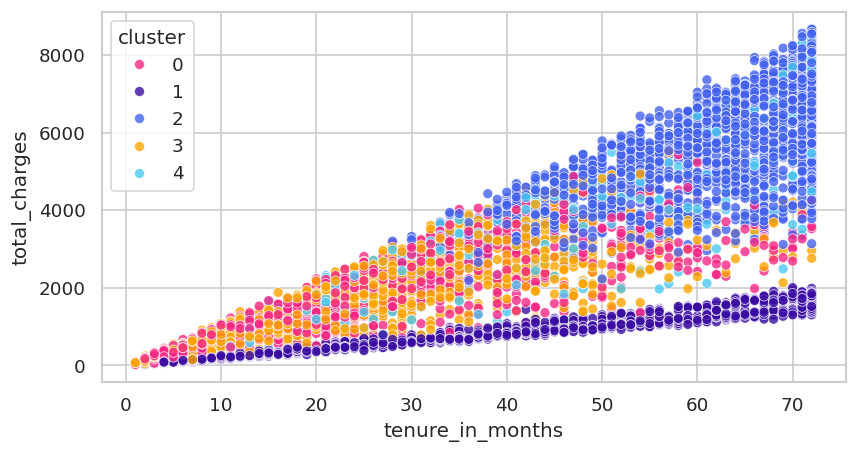

In [29]:
plt.figure(figsize=(8, 4),dpi=120)
palette=["#F72585", "#3A0CA3", "#4361EE","orange", "#4CC9F0"]
sns.scatterplot(data=df_cluster, x='tenure_in_months', y='total_charges',
                hue = 'cluster', palette=palette, alpha=0.8)#, markers={"Stayed": ".", "Churned": "X"})
plt.show()

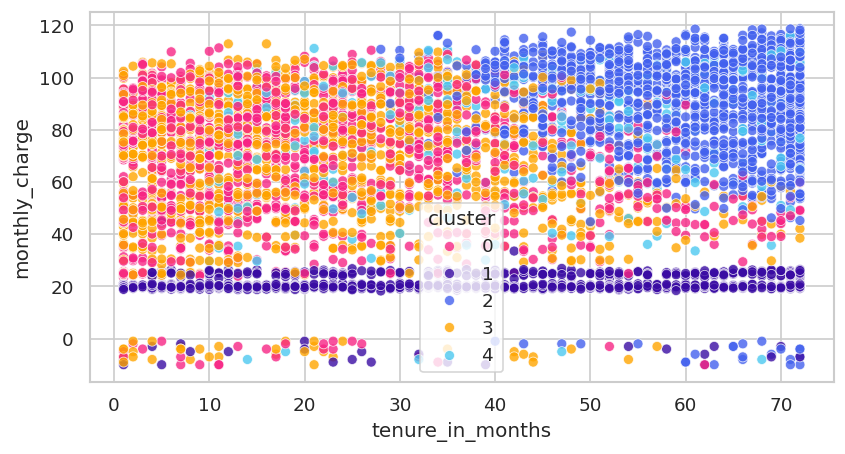

In [30]:
plt.figure(figsize=(8, 4),dpi=120)
sns.scatterplot(data=df_cluster, x='tenure_in_months', y='monthly_charge',
                hue = 'cluster', palette=palette, alpha=0.8)#, markers={"Stayed": ".", "Churned": "X"})
plt.show()

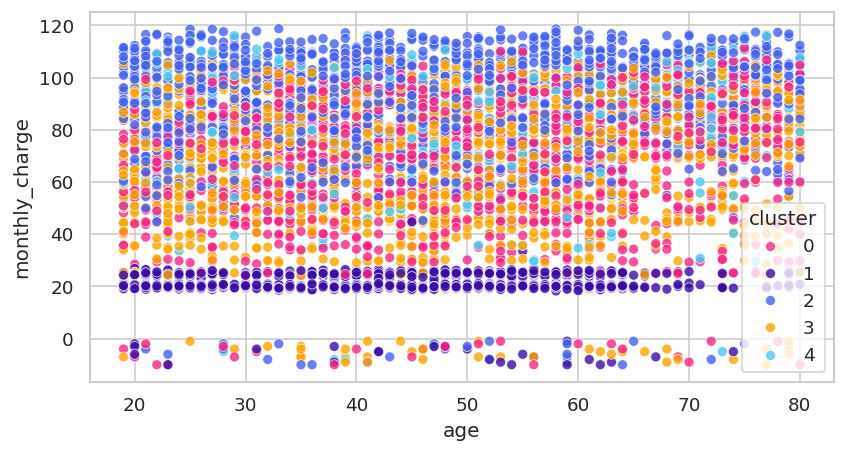

In [31]:
plt.figure(figsize=(8, 4),dpi=120)
sns.scatterplot(data=df_cluster, x='age', y='monthly_charge',
                hue = 'cluster', palette=palette, alpha=0.8)#, markers={"Stayed": ".", "Churned": "X"})
plt.show()

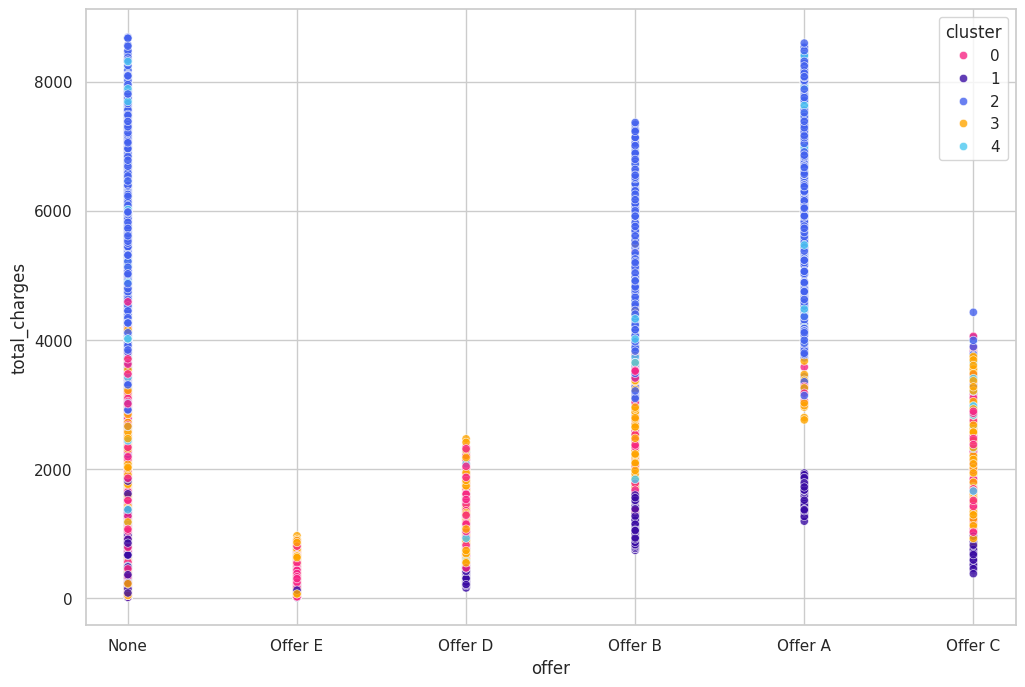

In [32]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_cluster, x='offer', y='total_charges',
                hue = 'cluster', palette=palette, alpha=0.8)#, markers={"Stayed": ".", "Churned": "X"})
plt.show()

# **ML Modeling**

In [33]:
df.head()

gender  age married  number_of_family_dependents city  zip_code   latitude  \
0  Female   37     Yes                            0   SD     93225  34.827662   
1    Male   46      No                            0   SD     91206  34.162515   
2    Male   50      No                            0   SD     92627  33.645672   
3    Male   78     Yes                            0   SD     94553  38.014457   
4  Female   75     Yes                            0   SD     93010  34.227846   

    longitude  number_of_referrals  tenure_in_months    offer  \
0 -118.999073                    2                 9     None   
1 -118.203869                    0                 9     None   
2 -117.922613                    0                 4  Offer E   
3 -122.115432                    1                13  Offer D   
4 -119.079903                    3                 3     None   

  internet_service internet_type  avg_monthly_gb_download online_security  \
0              Yes         Cable                     16.0              No   
1              Yes         Cable                     10.0              No   
2              Yes   Fiber Optic                     30.0              No   
3              Yes   Fiber Optic                      4.0              No   
4              Yes   Fiber Optic                     11.0              No   

  online_backup device_protection_plan premium_tech_support streaming_tv  \
0           Yes                     No                  Yes          Yes   
1            No                     No                   No           No   
2            No                    Yes                   No           No   
3           Yes                    Yes                   No          Yes   
4            No                     No                  Yes          Yes   

  streaming_movies streaming_music unlimited_hi-res_streaming  \
0               No              No                        Yes   
1              Yes             Yes                         No   
2               No              No                        Yes   
3              Yes              No                        Yes   
4               No              No                        Yes   

  subscription_type paperless_billing   payment_method  monthly_charge  \
0          One Year               Yes      Credit Card            65.6   
1    Month-to-Month                No      Credit Card            -4.0   
2    Month-to-Month               Yes  Bank Withdrawal            73.9   
3    Month-to-Month               Yes  Bank Withdrawal            98.0   
4    Month-to-Month               Yes      Credit Card            83.9   

   total_charges  total_refunds  total_extra_data_charges  \
0         593.30           0.00                         0   
1         542.40          38.33                        10   
2         280.85           0.00                         0   
3        1237.85           0.00                         0   
4         267.40           0.00                         0   

   total_long_distance_charges  total_revenue viewer_status  
0                       381.51         974.81        Stayed  
1                        96.21         610.28        Stayed  
2                       134.60         415.45       Churned  
3                       361.66        1599.51       Churned  
4                        22.14         289.54       Churned

## **Logistic Regression for interpretation**

In [34]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.drop(['viewer_status']).tolist()

X = df[numerical_features + categorical_features]
y = df['viewer_status'].map({'Churned':1, 'Stayed':0})

# Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_features])
X_scaled = pd.DataFrame(X_scaled, columns = numerical_features)


# Combining scaled numerical features and categorical features
X_preprocessed = pd.concat((X_scaled, X[categorical_features]), axis=1)
X_preprocessed = pd.get_dummies(X_preprocessed, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.shape

(5270, 42)

In [35]:
X_preprocessed.head()

age  number_of_family_dependents  zip_code  latitude  longitude  \
0 -0.579437                    -0.491665 -0.143473 -0.555056   0.351851   
1 -0.044980                    -0.491665 -1.230374 -0.824086   0.720740   
2  0.192557                    -0.491665 -0.465399 -1.033131   0.851212   
3  1.855312                    -0.491665  0.571437  0.733894  -1.093803   
4  1.677160                    -0.491665 -0.259216 -0.797662   0.314355   

   number_of_referrals  tenure_in_months  avg_monthly_gb_download  \
0            -0.006977         -1.063833                -0.239022   
1            -0.668355         -1.063833                -0.533052   
2            -0.668355         -1.272474                 0.447048   
3            -0.337666         -0.896919                -0.827083   
4             0.323712         -1.314203                -0.484047   

   monthly_charge  total_charges  total_refunds  total_extra_data_charges  \
0        0.018526      -0.811620      -0.256154                 -0.277898   
1       -2.219714      -0.834098       4.461377                  0.109653   
2        0.285443      -0.949598      -0.256154                 -0.277898   
3        1.060466      -0.526988      -0.256154                 -0.277898   
4        0.607029      -0.955538      -0.256154                 -0.277898   

   total_long_distance_charges  total_revenue  gender_Male  married_Yes  \
0                    -0.487945      -0.791775            0            1   
1                    -0.822111      -0.919508            1            0   
2                    -0.777145      -0.987778            1            0   
3                    -0.511194      -0.572876            1            1   
4                    -0.908867      -1.031898            0            1   

   city_SD  city_SF  city_SJ  offer_Offer A  offer_Offer B  offer_Offer C  \
0        1        0        0              0              0              0   
1        1        0        0              0              0              0   
2        1        0        0              0              0              0   
3        1        0        0              0              0              0   
4        1        0        0              0              0              0   

   offer_Offer D  offer_Offer E  internet_service_Yes  internet_type_DSL  \
0              0              0                     1                  0   
1              0              0                     1                  0   
2              0              1                     1                  0   
3              1              0                     1                  0   
4              0              0                     1                  0   

   internet_type_Fiber Optic  internet_type_None  online_security_Yes  \
0                          0                   0                    0   
1                          0                   0                    0   
2                          1                   0                    0   
3                          1                   0                    0   
4                          1                   0                    0   

   online_backup_Yes  device_protection_plan_Yes  premium_tech_support_Yes  \
0                  1                           0                         1   
1                  0                           0                         0   
2                  0                           1                         0   
3                  1                           1                         0   
4                  0                           0                         1   

   streaming_tv_Yes  streaming_movies_Yes  streaming_music_Yes  \
0                 1                     0                    0   
1                 0                     1                    1   
2                 0                     0                    0   
3                 1                     1                    0   
4                 1                     0                    0   

   

In [36]:
model = sm.Logit(y_train, X_train)
result = model.fit(maxiter=500)

result.summary()


Optimization terminated successfully.
         Current function value: 0.330658
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          viewer_status   No. Observations:                 5270
Model:                          Logit   Df Residuals:                     5230
Method:                           MLE   Df Model:                           39
Date:                Wed, 20 Mar 2024   Pseudo R-squ.:                  0.4464
Time:                        05:15:12   Log-Likelihood:                -1742.6
converged:                       True   LL-Null:                       -3147.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.2159        nan        nan        nan         nan         nan
age                                0.1967      0.056      3.505      0.000       0.087       0.307
number_of_family_dependents       -0.6035      0.068     -8.922      0.000      -0.736      -0.471
zip_code                           0.0029      0.111      0.026      0.979      -0.216       0.221
latitude                          -0.2872      0.135     -2.134      0.033      -0.551      -0.023
longitude                         -0.2339      0.096     -2.431      0.015      -0.422      -0.045
number_of_referrals               -1.5203      0.113    -13.459      0.000      -1.742      -1.299
tenure_in_months                  -1.9086      0.207     -9.242      0.000      -2.313      -1.504
avg_monthly_gb_download            0.0222      0.059      0.377      0.706      -0.093       0.138
monthly_charge                     0.2044      0.107      1.914      0.056      -0.005       0.414
total_charges                      0.8168   3.07e+06   2.66e-07      1.000   -6.02e+06    6.02e+06
total_refunds                     -0.0812    1.1e+04  -7.37e-06      1.000   -2.16e+04    2.16e+04
total_extra_data_charges           0.0112    3.5e+04   3.21e-07      1.000   -6.86e+04    6.86e+04
total_long_distance_charges       -0.2681   1.16e+06  -2.32e-07      1.000   -2.27e+06    2.27e+06
total_revenue                      0.5682   3.87e+06   1.47e-07      1.000   -7.58e+06    7.58e+06
gender_Male                       -0.0268      0.085     -0.315      0.753      -0.194       0.140
married_Yes                        1.5508      0.127     12.254      0.000       1.303       1.799
city_SD                           -0.0308      0.247     -0.124      0.901      -0.516       0.454
city_SF                           -0.3045      0.261     -1.166      0.244      -0.817       0.208
city_SJ                           -0.2397      0.259     -0.925      0.355      -0.748       0.268
offer_Offer A                      0.8454      0.284      2.975      0.003       0.289       1.402
offer_Offer B                     -0.0785      0.179     -0.438      0.662      -0.430       0.273
offer_Offer C                     -0.4211      0.179     -2.346      0.019      -0.773      -0.069
offer_Offer D                     -0.7529      0.140     -5.369      0.000      -1.028      -0.478
offer_Offer E                      0.3120      0.140      2.232      0.026       0.038       0.586
internet_service_Yes              -0.1270        nan        nan        nan         nan         nan
internet_type_DSL                 -0.2121      0.158     -1.345      0.179      -0.521       0.097
internet_type_Fiber Optic         -0.1711      0.181     -0.946      0.344      -0.526       0.183
internet_type_None                -1.0889        nan        nan        nan         nan         nan
online_security_Yes               -0.4727      0.110     -4.315      0.00

Coefficient       P-value Color
subscription_type_Two Year    -2.482967  2.364342e-35  blue
tenure_in_months              -1.908641  2.419978e-20  blue
married_Yes                    1.550815  1.602363e-34  blue
number_of_referrals           -1.520330  2.744144e-41  blue
subscription_type_One Year    -1.241504  5.046302e-22  blue
...                                 ...           ...   ...
streaming_movies_Yes           0.027719  8.732437e-01   red
gender_Male                   -0.026764  7.530850e-01   red
avg_monthly_gb_download        0.022223  7.060451e-01   red
total_extra_data_charges       0.011221  9.999997e-01   red
zip_code                       0.002905  9.792022e-01   red

[41 rows x 3 columns]

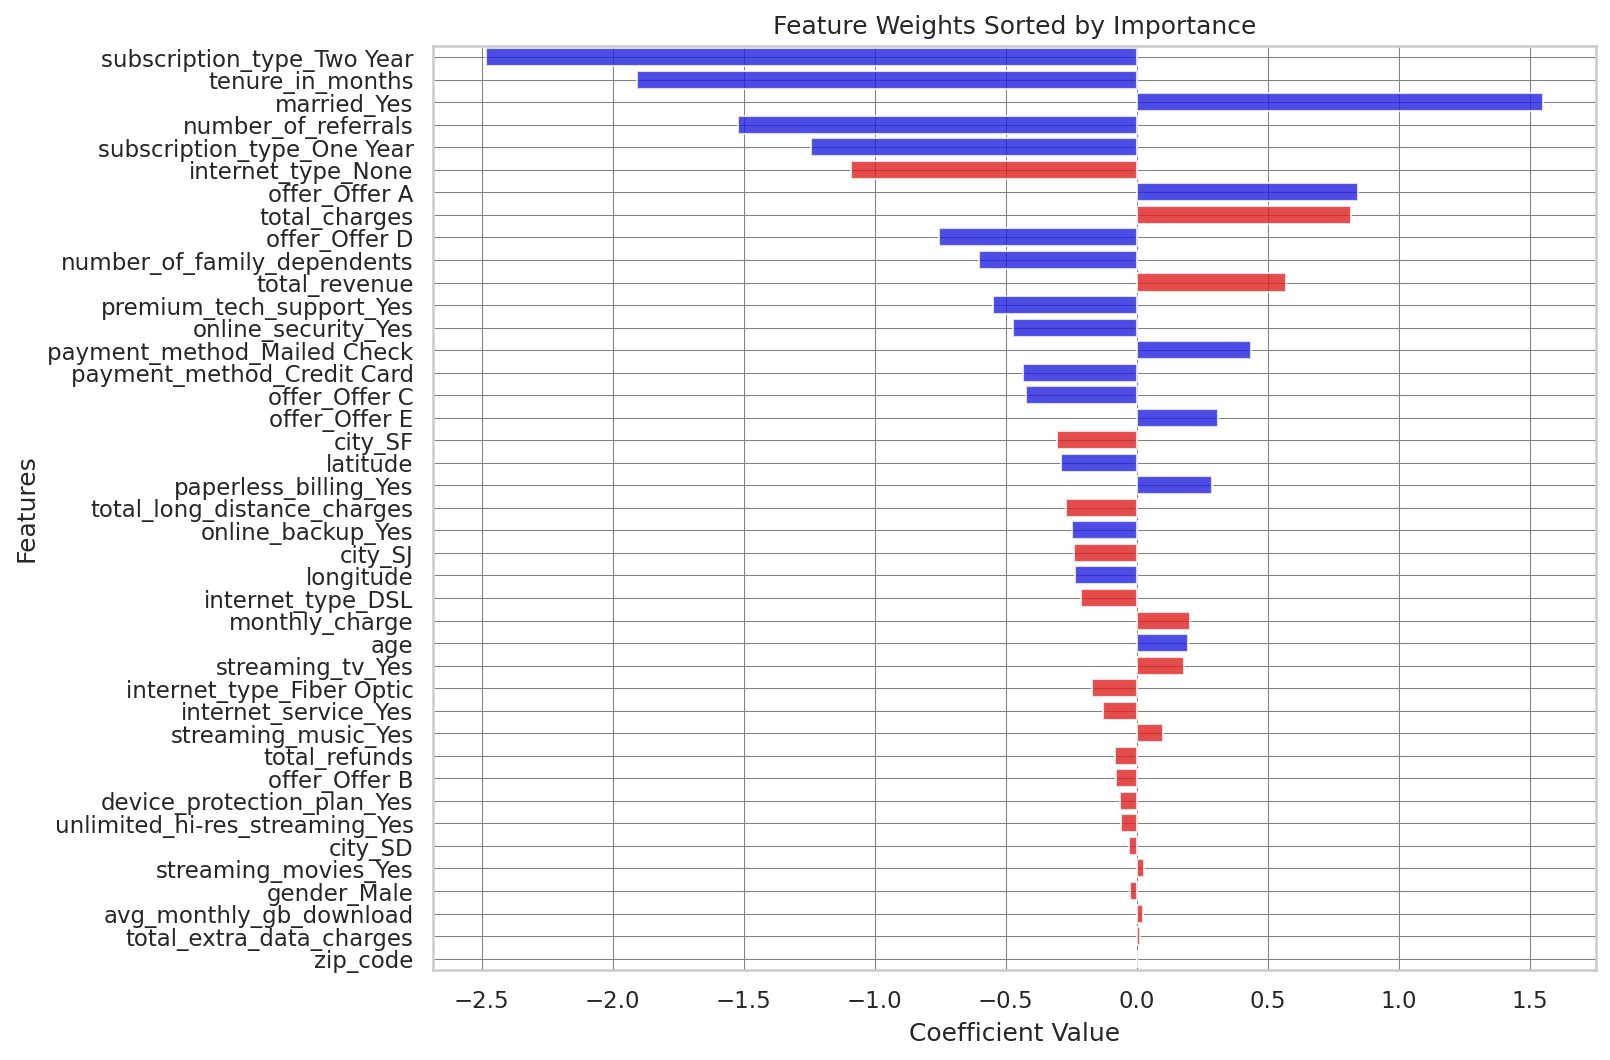

In [37]:

coefficients = result.params
p_values = result.pvalues

coef_df = pd.DataFrame({'Coefficient': coefficients, 'P-value': p_values})
coef_df = coef_df[~coef_df.index.isin(['const'])]
coef_df_sorted = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

# ["#F72585", "#3A0CA3", "#4361EE","#7209B7", "#4CC9F0"]
# Assign colors based on p-value significance
coef_df_sorted['Color'] = np.where(coef_df_sorted['P-value'] <= 0.05, 'blue', 'red')
display(coef_df_sorted)

plt.figure(figsize=(10, 8),dpi=150)
sns.barplot(x='Coefficient', y=coef_df_sorted.index, data=coef_df_sorted, palette=coef_df_sorted['Color'].tolist(), alpha=0.8)

# Adding grid lines
plt.grid(True, which='both', axis='x', color='gray', linestyle='-', linewidth=0.5)
plt.grid(True, which='both', axis='y', color='gray', linestyle='-', linewidth=0.5)
plt.title('Feature Weights Sorted by Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


### **Evaluation with Precision&Recall F1, AUC ROC**

In [38]:
from sklearn.metrics import classification_report

# Predictions on the training and testing sets
y_train_pred = result.predict(X_train) > 0.5
y_test_pred = result.predict(X_test) > 0.5

# Generating classification reports
classification_report_train = classification_report(y_train, y_train_pred)
classification_report_test = classification_report(y_test, y_test_pred)
print(classification_report_train)
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3770
           1       0.74      0.73      0.74      1500

    accuracy                           0.85      5270
   macro avg       0.82      0.82      0.82      5270
weighted avg       0.85      0.85      0.85      5270

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       949
           1       0.78      0.76      0.77       369

    accuracy                           0.87      1318
   macro avg       0.85      0.84      0.84      1318
weighted avg       0.87      0.87      0.87      1318



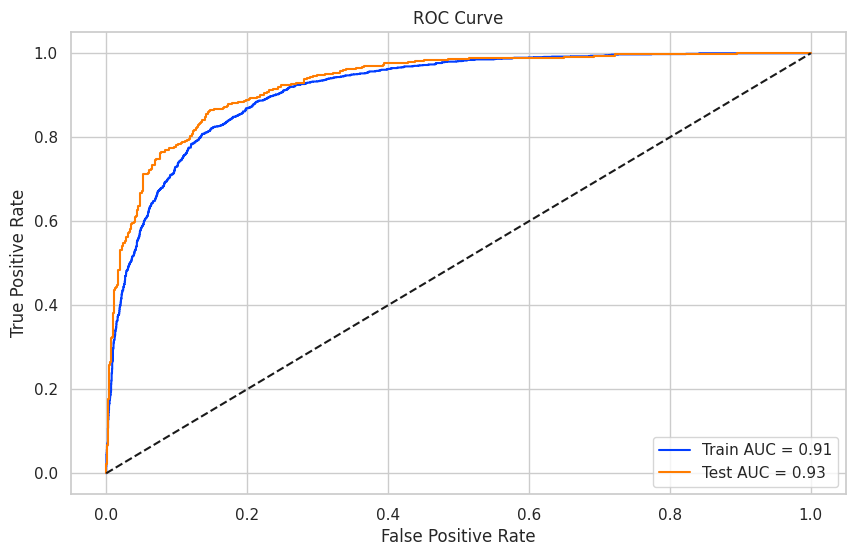

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_train_pred_prob = result.predict(X_train)
y_test_pred_prob = result.predict(X_test)
# Calculate the ROC curve and AUC for the training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
auc_train = auc(fpr_train, tpr_train)

# Calculate the ROC curve and AUC for the testing data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
auc_test = auc(fpr_test, tpr_test)

# Plotting the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal for reference

# Adding labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## **XGBoost for better performance**

In [40]:
from xgboost import XGBClassifier as xgb
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.drop(['viewer_status']).tolist()

X = df.copy()
y = df['viewer_status'].map({'Churned':1, 'Stayed':0})

X_preprocessed = X[X.columns.difference(['viewer_status'])]
X_preprocessed = pd.get_dummies(X_preprocessed, drop_first=True)

X_train = X_train[X_train.columns.difference(['tenure_in_months'])]
X_test = X_test[X_test.columns.difference(['tenure_in_months'])]
Best_parameters= {'max_depth': 4, 'n_estimators': 150, 'learning_rate': 0.12758620689655173, 'subsample': 0.8,
                  'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}
model = xgb(**Best_parameters).fit(X_train, y_train)


### **Evaluation with Precision&Recall F1, AUC ROC**

In [41]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

report_train = classification_report(y_train, y_train_pred)
report_test = classification_report(y_test, y_test_pred)

print("Classification Report for Training Data:\n", report_train)
print("Classification Report for Testing Data:\n", report_test)

Classification Report for Training Data:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      3770
           1       0.91      0.84      0.88      1500

    accuracy                           0.93      5270
   macro avg       0.93      0.91      0.92      5270
weighted avg       0.93      0.93      0.93      5270

Classification Report for Testing Data:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       949
           1       0.82      0.78      0.80       369

    accuracy                           0.89      1318
   macro avg       0.87      0.86      0.86      1318
weighted avg       0.89      0.89      0.89      1318



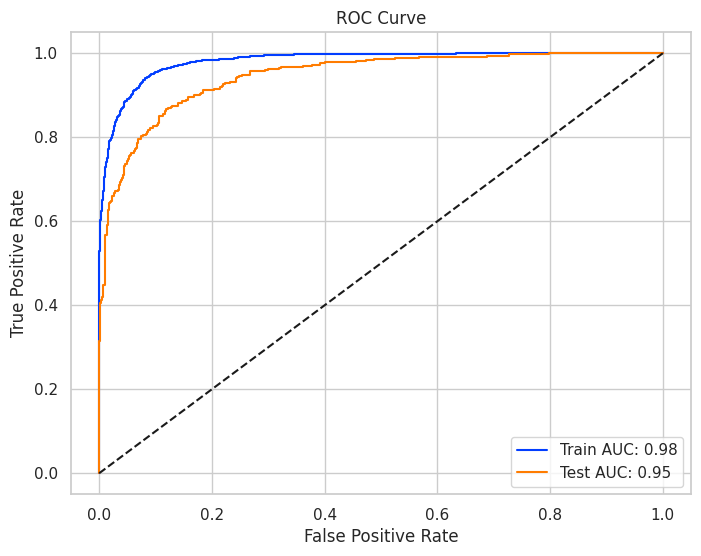

In [42]:
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC: {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC: {auc_test:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

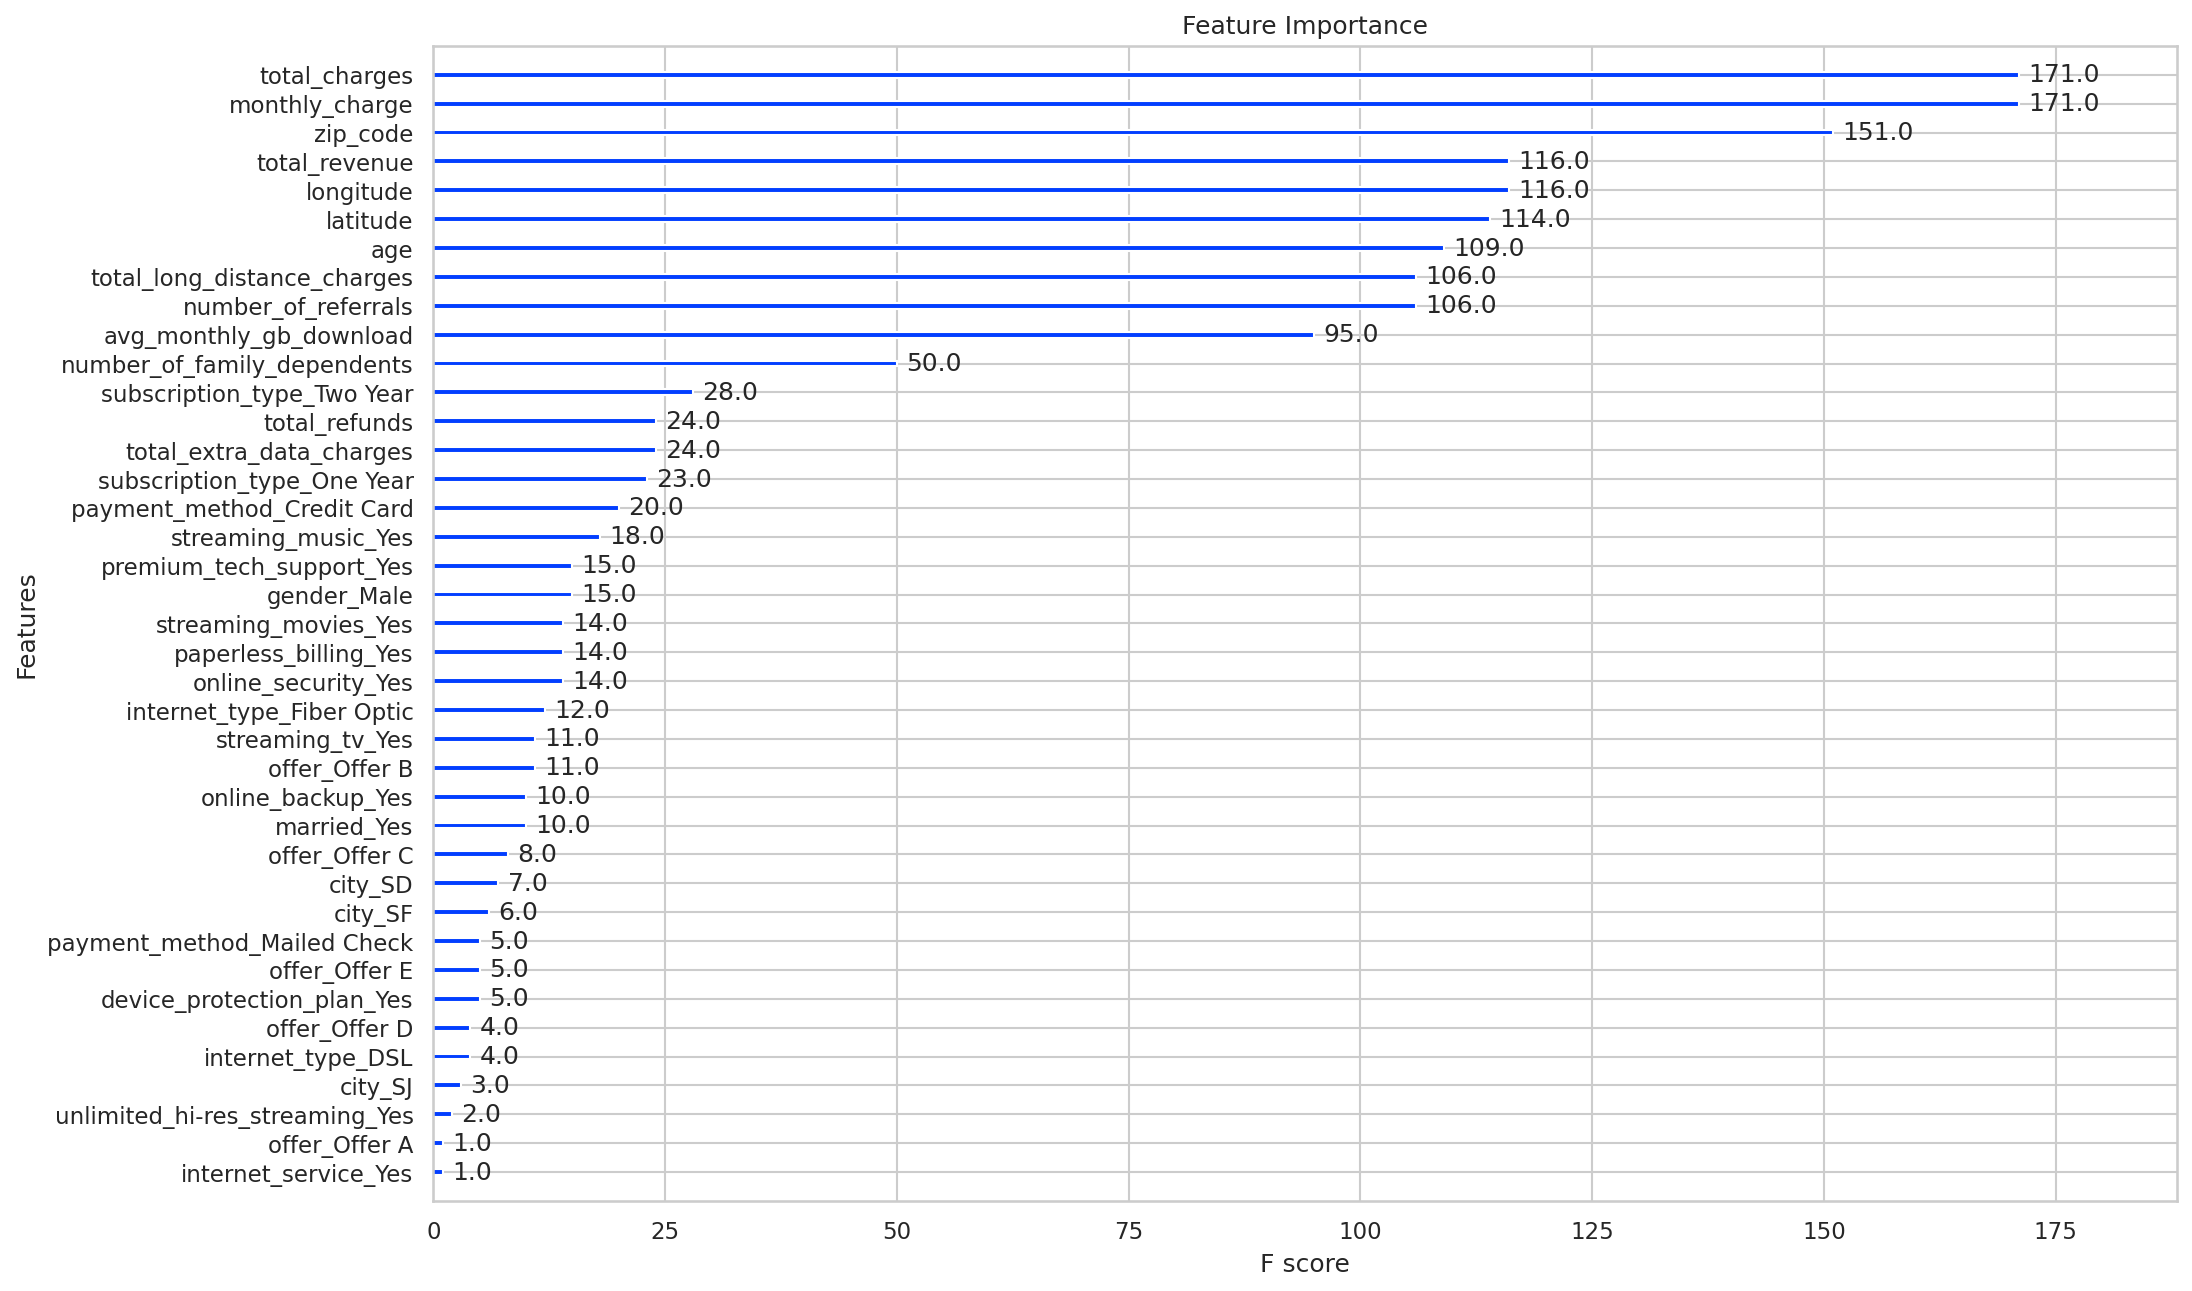

In [43]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(15, 10), dpi=150)
plot_importance(model, importance_type='weight', title='Feature Importance', ax=ax)
plt.show()

## **Interpret Decision Trees**

 99%|===================| 5199/5270 [00:35<00:00]       

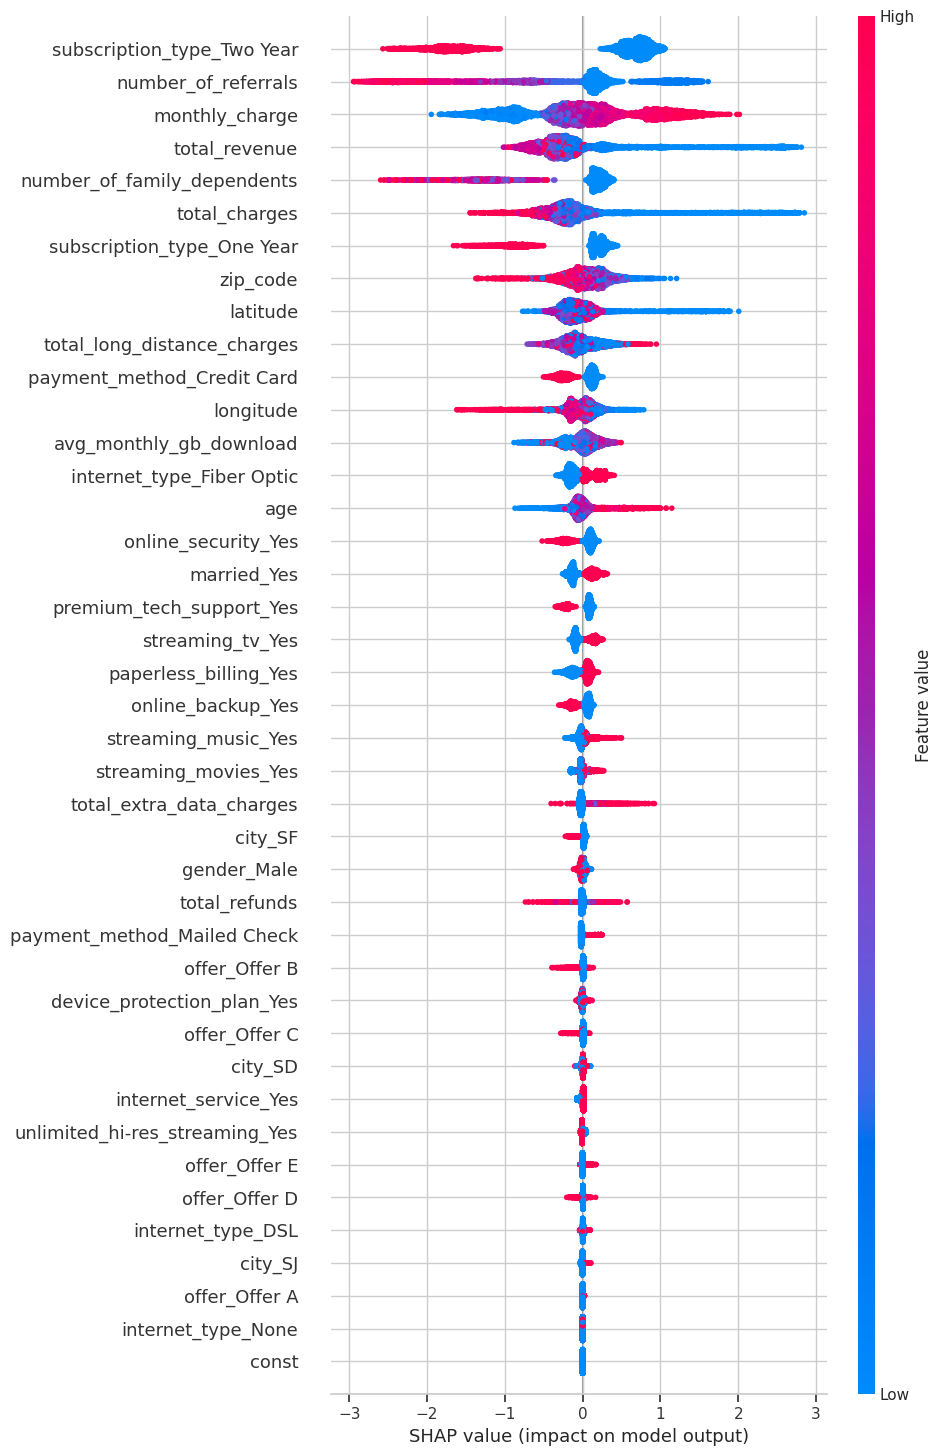

In [ ]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])

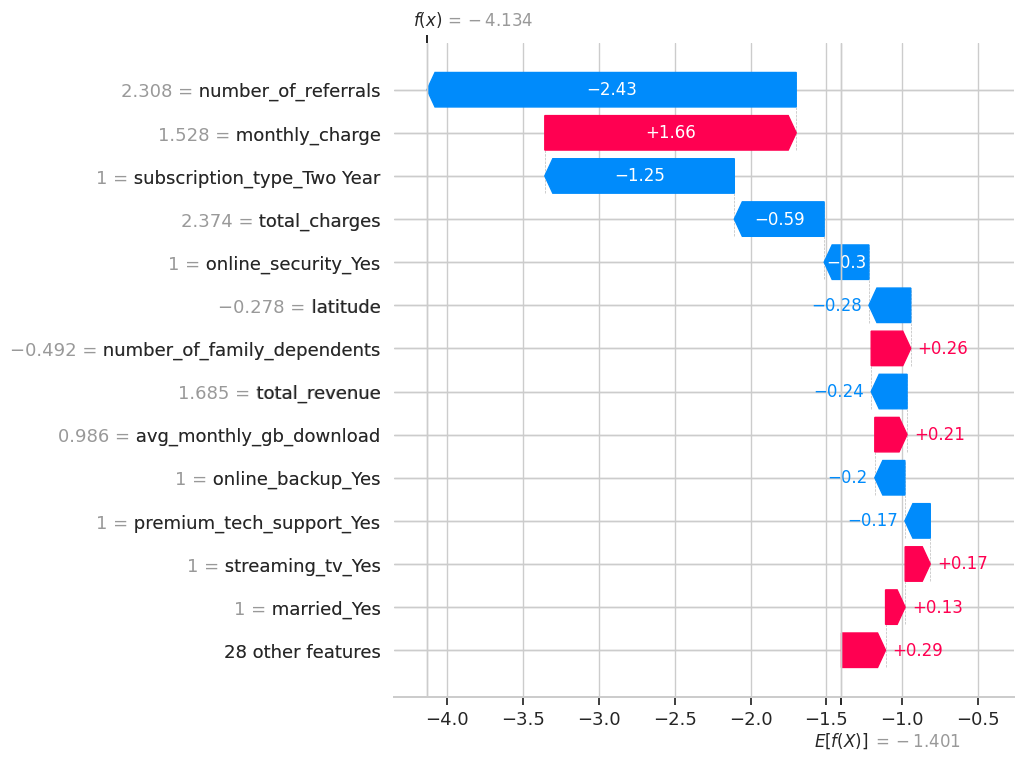

In [ ]:
chosen_instance = X_train.iloc[0]
shap_values_instance = explainer.shap_values(chosen_instance)

# Generate the waterfall plot for the chosen instance
shap.plots.waterfall(shap_values[0], max_display=14)

Explainer expected value: [-0.86148012]


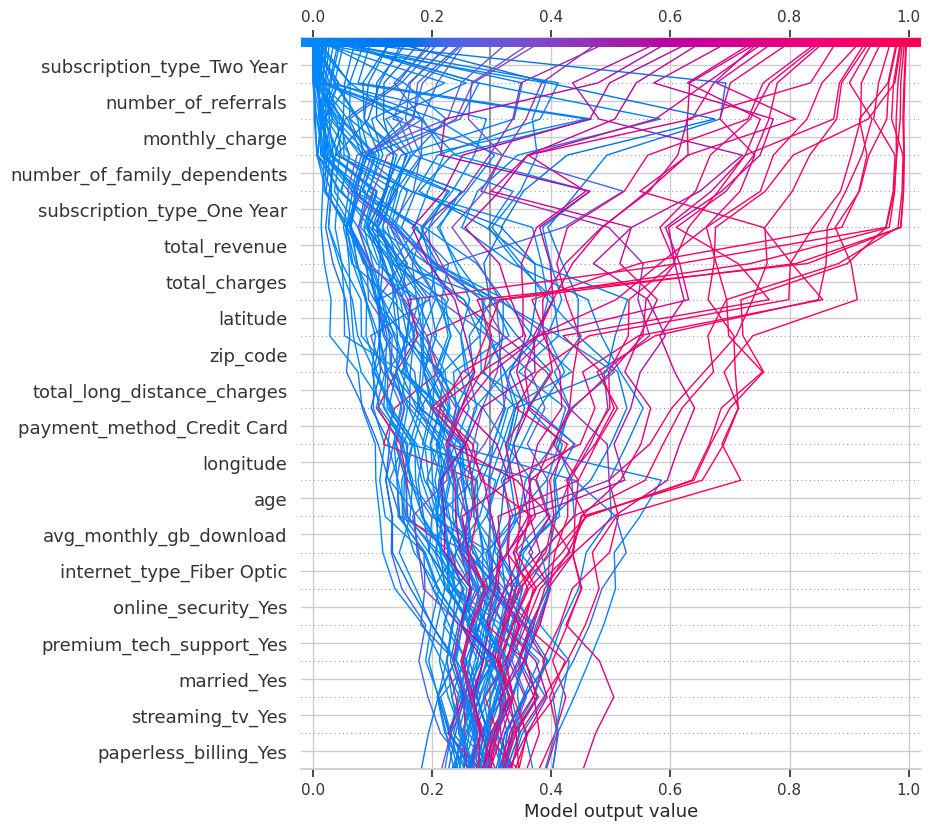

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model )
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

shap_values = explainer.shap_values(X_train.iloc[:100])
shap.decision_plot(expected_value, shap_values, X_test.columns, link="logit")

In [60]:
# # shap_values_instance = explainer.shap_values(X_train.iloc[:100])
# shap.initjs()
# shap.force_plot(explainer.expected_value, explainer.shap_values(X_train.iloc[:10]), X_train.iloc[:10])

## **Grid/Random Search**

In [57]:
param_space = {
    'max_depth': np.arange(3, 10),  # Depths from 3 to 9, control overfitting
    'n_estimators': [60, 80, 100, 130, 160, 200],  # Number of boosting rounds, balance between speed and accuracy
    'learning_rate': np.linspace(0.08, 0.4, 30),  # Makes the model more robust by shrinking the weights on each step
    'subsample': np.linspace(0.5, 1, 6),  # Subsample ratio of the training instances, prevents overfitting
    'colsample_bytree': np.linspace(0.5, 1, 6),  # Subsample ratio of columns when constructing each tree, for diversity
    'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child, controls overfitting
    'gamma': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],  # Minimum loss reduction required to make a further partition on a leaf node, controls overfitting
    'reg_alpha': [0.1, 0.3, 0.5, 1],  # L1 regularization term on weights, increases model sparsity
    'reg_lambda': [1, 0.5, 0.1, 0.01],  # L2 regularization term on weights, combats overfitting
}


In [58]:
import random

n_combinations = 100
# Function to randomly sample a combination of hyperparameters
def random_combination(param_space, n_combinations):
    combinations = []
    for _ in range(n_combinations):
        params = {key: random.choice(value) for key, value in param_space.items()}
        combinations.append(params)
    return combinations

random_combos = random_combination(param_space, n_combinations)


In [59]:
from sklearn.metrics import recall_score
best_recall = float("-inf")
best_params = None

for params in tqdm(random_combos, desc="Random searching..."):
    model = xgb(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    recall = recall_score(y_test, predictions)  # Assuming your positive class is labeled as 1
    print(recall, params)

    if recall > best_recall:
        best_recall = recall
        best_params = params

print("Best Recall:", best_recall)
print("Best parameters:", best_params)


Random searching...:   0%|          | 0/100 [00:00<?, ?it/s]

0.7723577235772358 {'max_depth': 6, 'n_estimators': 60, 'learning_rate': 0.11310344827586208, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 3, 'gamma': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}
0.7479674796747967 {'max_depth': 5, 'n_estimators': 130, 'learning_rate': 0.15724137931034482, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 2, 'gamma': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
0.7723577235772358 {'max_depth': 3, 'n_estimators': 100, 'learning_rate': 0.4, 'subsample': 1.0, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'gamma': 0.2, 'reg_alpha': 1, 'reg_lambda': 0.01}
0.7533875338753387 {'max_depth': 7, 'n_estimators': 130, 'learning_rate': 0.366896551724138, 'subsample': 0.8, 'colsample_bytree': 0.9, 'min_child_weight': 2, 'gamma': 0.05, 'reg_alpha': 1, 'reg_lambda': 1}
0.7615176151761518 {'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.12413793103448276, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight': 3, 'gamma': 0.5, 'reg

# **Retention Strategies**

**5 Most Important Factors Influencing Churn**
The beeswarm plot shows the features that most significantly impact the model's output. The top contributing features (either positive or negative impact) will be our most important factors.\
<font color='Blue'>
1.Number of Referrals: More referrals might decrease the likelihood of churn.\
2.Monthly Charges: Customers with high monthly charge has high likelihood to churn.\
3.Total Revenue: Higher total charges could decrease the likelihood of churn, it would indicate loyal customers.\
4.Subscription Type: Subsciprions of Two-Year and One-Year customers are much less likely to churn than monthly subscription.\
5.Age/Marry: Older and Married people tend to churn more likely.


**Identifying Customer Segments at Highest Risk of Churn**
Using the insights from the XGBoost model, we can define customer segments as follows:

High Monthly Charge Customers: Those paying more each month are at a higher risk of churn.\
Low Referral Count Customers: Customers with fewer referrals are at a higher risk.\
Short-Term Subscribers: Customers with shorter subscription lengths might be more prone to churn.\
Low Total Revenue Customers: Those contributing less in terms of total revenue could be at higher risk.\
High Total Charge Customers: If higher total charges correspond to long-term customers, they may have a lower risk of churn, but this needs further analysis.

**Recommendations for Reducing Churn for Each Segment**
For each segment, tailored strategies can be developed:

High Monthly Charge Customers: Review pricing strategies and consider introducing loyalty discounts or value-added services to provide more perceived value.

Low Referral Count Customers: Implement a referral program that incentivizes customers to refer new customers. Offer benefits both to the referrer and the referred to boost this metric.

Short-Term Subscribers: Create benefits for subscription renewal, such as a discount for the next billing cycle or additional services after renewal, to encourage longer subscription periods.

Low Total Revenue Customers: Offer personalized upsell opportunities or bundle deals that can enhance the customer's experience while increasing their total revenue contribution.

High Total Charge Customers: For long-term customers with high total charges, ensure a high-quality customer service experience, introduce loyalty programs, and regularly engage with them to maintain a strong relationship.

Loyalty Programs: Introduce or enhance loyalty programs that reward long-term subscriptions and referrals. This could include discounts, exclusive content access, or other benefits that increase with tenure and referrals.

Family Plans Promotion: Encourage customers to add family dependents by promoting the value and convenience of family plans, possibly through targeted marketing campaigns that highlight shared experiences and savings.

Tailored Content and Features for Older Customers: Investigate and address the specific needs or preferences of older customers. This could involve user interface improvements for accessibility, curated content collections, or features that enhance the viewing experience for this demographic.

Incentivize Longer Subscription Commitments: Offer incentives for customers to switch from month-to-month to longer-term subscriptions, such as price discounts, enhanced service features, or trial periods for premium content.

Engagement and Satisfaction Surveys: Regularly engage with customers through satisfaction surveys and feedback mechanisms. Use this data to refine and personalize the service, addressing any concerns or preferences that may lead to churn.


In [62]:
df.to_csv("netflix_churn_cleaned.csv")